## Import libraries and settings

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# For creating colormaps
import matplotlib.cm as cm

plt.style.use('fivethirtyeight')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

In [2]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'worldwide_adj', 'budget_adj',  'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money domestically
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

# Only look at movies with budget information
data = data[data['budget_adj'].notna()]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['worldwide_breakeven'] = data['worldwide_adj'] >= 3 * data['budget_adj']

# For profit analysis
data['profit'] = data['worldwide_adj'] - 3 * data['budget_adj']

# For checking out the ratio of gross to budget for each movie/genre
data['gross_budget_ratio'] = data['worldwide_adj'] / data['budget_adj']

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

# Create dataframes for the genres
#action = data[data['genres_mojo'].str.contains('Action', na=False)]
#adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
#comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
#drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
#horror = data[data['genres_mojo'].str.contains('Horror', na=False)]
#thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 20 to 19775
Data columns (total 18 columns):
title                  3749 non-null object
release_year           3749 non-null int64
distributor_mojo       3749 non-null object
genres_mojo            3749 non-null object
release_date           3749 non-null datetime64[ns]
worldwide_adj          3749 non-null float64
budget_adj             3749 non-null float64
release_week           3749 non-null int64
release_decade         3749 non-null int64
worldwide_breakeven    3749 non-null bool
profit                 3749 non-null float64
gross_budget_ratio     3749 non-null float64
action                 3749 non-null bool
adventure              3749 non-null bool
comedy                 3749 non-null bool
drama                  3749 non-null bool
horror                 3749 non-null bool
thriller_suspense      3749 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 377.1+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [4]:
data[data['budget_adj'].notna() & data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Universal                           355
Warner Bros.                        346
Fox                                 301
Sony / Columbia                     266
Paramount                           264
Buena Vista                         217
New Line                            122
Miramax                             114
Fox Searchlight                     106
Lionsgate                           104
MGM                                  89
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Warner Bros. (New Line)              49
Weinstein Company                    49
IFC                                  46
DreamWorks                           42
Magnolia                             41
Columbia                             41
United Artists                       41
Lions Gate                           41
Roadside Attractions                 35
TriStar                              34
Sony (Revolution)                    30


In [5]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal         355
Focus Features     64
DreamWorks         42
Gramercy           13
Focus World         3
Name: distributor_mojo, dtype: int64
Sum: 477


In [6]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 264
Paramount (DreamWorks)     18
Paramount Vantage          14
Paramount Classics         10
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 308


In [7]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               346
New Line                   122
Warner Bros. (New Line)     49
Name: distributor_mojo, dtype: int64
Sum: 517


In [8]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                301
Buena Vista        217
Fox Searchlight    106
Fox Atomic           3
Disney               1
Name: distributor_mojo, dtype: int64
Sum: 628


In [9]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia        266
Sony Classics           81
Sony / Screen Gems      69
Columbia                41
TriStar                 34
Sony (Revolution)       30
Sony / AFFIRM Films      2
Name: distributor_mojo, dtype: int64
Sum: 523


In [10]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [11]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

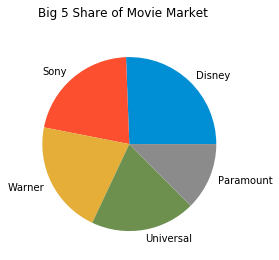

In [12]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

figure, axis = plt.subplots()
figure.suptitle('Big 5 Share of Movie Market')

data['distributor'].value_counts().plot(kind='pie')
axis.set_ylabel('');

## Check Movies By Decade

We have very few movies from before the 1970s. We will remove these entries to simplify our analysis.

In [13]:
data['release_decade'].value_counts()

2000    1047
2010     740
1990     501
1980     114
1970      31
1960       9
1950       8
1930       2
1940       1
Name: release_decade, dtype: int64

In [14]:
data = data[data['release_decade'] >= 1970]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 20 to 19775
Data columns (total 24 columns):
title                  2433 non-null object
release_year           2433 non-null int64
distributor_mojo       2433 non-null object
genres_mojo            2433 non-null object
release_date           2433 non-null datetime64[ns]
worldwide_adj          2433 non-null float64
budget_adj             2433 non-null float64
release_week           2433 non-null int64
release_decade         2433 non-null int64
worldwide_breakeven    2433 non-null bool
profit                 2433 non-null float64
gross_budget_ratio     2433 non-null float64
action                 2433 non-null bool
adventure              2433 non-null bool
comedy                 2433 non-null bool
drama                  2433 non-null bool
horror                 2433 non-null bool
thriller_suspense      2433 non-null bool
universal              2433 non-null bool
paramount              2433 non-null bool
warner              

## Summary

Our filtered dataset now has 2,433 entries. 

The movie studios all have a fair chunk of the dataset. This will hopefully prevent bias stemming from lack of equitable market share.

We have no missing values, so we can do all monetary calculations safely. 

# Create Graphing Helper Function and Summary DataFrame

In [15]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html

# Function to add counts/percentages to bar plots
def autolabel(axis, num_decimals=0, counts=None):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(val.get_height())
        
        # We don't want to display zeros on our bar plots
        if (height == 0) or pd.isnull(height):
            continue
            
        # Put the count below a negative value bar
        if height < 0:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*0.95, '{}'.format(height), ha='center', va='bottom', fontsize=20)
        else:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=20)

In [16]:
# Create custom function to generate the color list when graphing
def generate_color_list(colors_needed=1, order_list=['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']):
    colors_available = ['color1', 'color2', 'color3']
    c_list = []
    
    # Matplotlib needs a list of colors if the graph doesn't have multiple columns per index
    if colors_needed == 1:
        c_list = [genres_dict[genre][colors_available[0]] for genre in order_list]
        return c_list
    
    # Matplotlib needs a list of tuples if the graph has multiple columns per index
    for i in range(colors_needed):
        temp_tuple = tuple([genres_dict[genre][colors_available[i]] for genre in order_list])
        c_list.append(temp_tuple)
        
    return c_list

In [133]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['#008FD5', '#FC4F30', '#E5AE38', '#6D904F', '#8B8B8B', '#810F7C']
colors2 = ['#87C7E5', '#F4BAB0', '#F4DBA8', '#C7E2AE', '#D6D1D1', '#CE8EDB']
colors3 = ['#C5E7F7', '#F4D7D2', '#F9ECD1', '#E3F2D5', '#EAE8E8', '#ECC8F4']

# Create a dictionary holding the colors for each genre
genres_dict = {
    'action': {'color1': '#008FD5', 'color2': '#87C7E5', 'color3': '#C5E7F7', 'colormap': 'Blues'},
    'adventure': {'color1': '#FC4F30', 'color2': '#F4BAB0', 'color3': '#F4D7D2', 'colormap': 'Oranges'},
    'comedy': {'color1': '#E5AE38', 'color2': '#F4DBA8', 'color3': '#F9ECD1', 'colormap': 'Reds'},
    'drama': {'color1': '#6D904F', 'color2': '#C7E2AE', 'color3': '#E3F2D5', 'colormap': 'Greens'},
    'horror': {'color1': '#8B8B8B', 'color2': '#D6D1D1', 'color3': '#EAE8E8', 'colormap': 'Greys'},
    'thriller_suspense': {'color1': '#810F7C', 'color2':  '#CE8EDB', 'color3': '#ECC8F4', 'colormap': 'Purples'}
    }

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)
# Median dollars earned for dollars spent
# Mean dollars earned for dollars spent
# Median profit
# Mean profit
# All-time profit
# Breakeven percentage
# Current decade (2010s) median profit
# Current decade (2010s) mean profit
# Current decade (2010s) all profit
# Current decade (2010s) breakeven percentage

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['worldwide_adj'].mean() / 1000000, 1) for genre in genres],
    'median_gross': [round(data[data[genre]]['worldwide_adj'].median() / 1000000, 1) for genre in genres], 
    'all_time_gross': [round(data[data[genre]]['worldwide_adj'].sum() / 1000000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'median_budget': [round(data[data[genre]]['budget_adj'].median() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].sum() / 1000000) / (3 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres],
    'median_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].median() / 1000000) / (3 * data[data[genre]]['budget_adj'].median() / 1000000), 1) for genre in genres],
    'mean_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].mean() / 1000000) / (3 * data[data[genre]]['budget_adj'].mean() / 1000000), 1) for genre in genres],
    'median_profit': [round((data[data[genre]]['profit'].median() / 1000000), 1) for genre in genres],
    'mean_profit': [round((data[data[genre]]['profit'].mean() / 1000000), 1) for genre in genres],
    'all_time_profit': [round(data[data[genre]]['profit'].sum() / 1000000000, 1) for genre in genres],
    'breakeven_percentage': [round(data[data[genre]]['worldwide_breakeven'].sum() / data[data[genre]]['worldwide_breakeven'].count() * 100, 1) for genre in genres],
    'current_decade_median_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].median() / 1000000), 1) for genre in genres],
    'current_decade_mean_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].mean() / 1000000), 1) for genre in genres],
    'current_decade_profit': [round(data[(data[genre]) & (data['release_year'] >=2010)]['profit'].sum() / 1000000000, 1) for genre in genres],
    'current_decade_breakeven_percentage': [round(data[(data[genre]) & (data['release_year'] >=2010)]['worldwide_breakeven'].mean() * 100, 1) for genre in genres],
    'current_decade_mean_gross_budget_ratio': [round(data[(data[genre]) & (data['release_year'] >=2010)]['gross_budget_ratio'].mean(), 1) for genre in genres],
    'current_decade_median_gross_budget_ratio': [round(data[(data[genre]) & (data['release_year'] >=2010)]['gross_budget_ratio'].median(), 1) for genre in genres]
}

# Bird's Eye View Of The Data

In [134]:
# Create a summary dataframe for simple graphs
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

,num_movies,avg_gross,median_gross,all_time_gross,avg_budget,median_budget,all_time_budget,dollars_earned_for_dollars_spent,median_dollars_earned_for_dollars_spent,mean_dollars_earned_for_dollars_spent,median_profit,mean_profit,all_time_profit,breakeven_percentage,current_decade_median_profit,current_decade_mean_profit,current_decade_profit,current_decade_breakeven_percentage,current_decade_mean_gross_budget_ratio,current_decade_median_gross_budget_ratio
action,479,315.6,208.5,151.2,102.5,90.3,49.1,1.0,0.8,1.0,-25.8,8.1,3.9,40.3,5.7,70.3,12.4,51.7,3.5,3.1
adventure,250,392.9,258.3,98.2,124.1,120.4,31.0,1.1,0.7,1.1,-45.6,20.6,5.2,39.2,10.4,72.5,6.5,50.6,4.2,3.1
comedy,955,131.1,77.6,125.2,45.6,35.8,43.6,1.0,0.7,1.0,-20.0,-5.8,-5.6,35.7,-12.7,-4.6,-1.2,39.1,3.3,2.5
drama,654,104.8,57.2,68.5,40.8,30.7,26.7,0.9,0.6,0.9,-24.7,-17.6,-11.5,33.9,-12.7,-0.4,-0.1,38.8,3.7,2.2
horror,252,174.3,95.9,43.9,44.4,31.5,11.2,1.3,1.0,1.3,-4.9,41.1,10.4,47.6,23.3,53.1,3.9,62.2,18.6,4.6
thriller_suspense,347,147.9,93.2,51.3,57.0,53.0,19.8,0.9,0.6,0.9,-36.3,-23.0,-8.0,32.6,-15.3,5.4,0.5,41.3,4.8,2.6


## Create custom function to help graphing by genre

In [29]:
# We want individual columns that hold a specific worldwide stat for each genre
# Since a movie can have multiple genres, right now we must isolate each genre with a groupby while looping over each genre
# If we create individual columns that contain information about a genre and a worldwide stat, it's easier to graph later
def worldwide_stat_by_genre(row, genre, stat):
    # Returns either 0 or the stat value due to boolean multiplication
    test = row[genre] * row[stat]
        
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# We want individual columns that store breakeven information for each genre
# Since we will be adding the entries in these columns (and using pd.DataFrame.mean()), we need to convert them to 1's and 0's
# Thus, we need to create a separate function from the 'worldwide_stat_by_genre' function
def test_for_breakeven_by_genre(row, genre, breakeven_column):
    if row[genre]:
        if row[breakeven_column]:
            return 1
        else:
            return 0
    else:
        return np.nan
    
# List of new columns to hold worldwide stats by genre
budget_columns = ['worldwide_budget_{}'.format(genre) for genre in genres]
gross_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]
profit_columns = ['worldwide_profit_{}'.format(genre) for genre in genres]
breakeven_columns = ['worldwide_breakeven_{}'.format(genre) for genre in genres]
gross_budget_ratio_columns = ['worldwide_gross_budget_ratio_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, budget_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'budget_adj'), axis=1)
    
for genre, col in zip(genres, gross_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'worldwide_adj'), axis=1)
    
for genre, col in zip(genres, profit_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'profit'), axis=1)
    
for genre, col in zip(genres, gross_budget_ratio_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'gross_budget_ratio'), axis=1)
    
for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: test_for_breakeven_by_genre(x, genre, 'worldwide_breakeven'), axis=1)

In [43]:
def show_median_profit_by_genre(genre, color):
    # Hack to allow 'thriller_suspense' to be searched as the regex 'Thriller|Suspense'
    genre = genre.replace('_', '|')
    
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit By {} Subgenres'.format(genre.title()), fontsize=20)

    only_genre_movies = data[data['genres_mojo'].str.contains('{}'.format(genre.title(), regex=True))]
    median = only_genre_movies['profit'].median() / 1000000

    grp = only_genre_movies.groupby('genres_mojo')['profit'].median().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=color)
    axis.axhline(median, color='k', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Median: {:.1f}'.format(median)], loc=3, fontsize=20)
    autolabel(axis);

In [45]:
def show_mean_profit_by_genre(genre, color):
    # Hack to allow 'thriller_suspense' to be searched as the regex 'Thriller|Suspense'
    genre = genre.replace('_', '|')
    
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Mean Profit By {} Subgenres'.format(genre.title()), fontsize=20)

    only_genre_movies = data[data['genres_mojo'].str.contains('{}'.format(genre.title(), regex=True))]
    mean = only_genre_movies['profit'].mean() / 1000000

    grp = only_genre_movies.groupby('genres_mojo')['profit'].mean().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=color)
    axis.axhline(mean, color='k', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Mean: {:.1f}'.format(mean)], loc=3, fontsize=20)
    autolabel(axis);

In [53]:
# Create custom function to determine the background color for labeling the genre with the highest stat per decade
def find_genre_for_background_color(groupby_instance, decade):
    column_name_list = groupby_instance.loc[decade].sort_values(ascending=False).index[0].split('_')
    
    # Check if the split string has length 4, if so it is thriller_suspense and requires extra filtering
    # The reason is our genres are 'action', 'adventure', 'comedy', 'drama', 'horror', and 'thriller_suspense'
    # Our worldwide stat column names have the following form: worldwide_(stat name)_genre
    # Thus five of our six genres will have length 3 when split on '_', but 'thriller_suspense' will have length 4
    if len(column_name_list) == 4:
        return '_'.join(column_name_list[-2:])
    
    # If the genre is not 'thriller_suspense', we just need the last word in the list
    return column_name_list[-1]

## Gross To Budget Ratio

It is also helpful to look at a movie's performance based on how much money it makes relative to its budget, or the **ratio of the worldwide gross to the budget**.

There are limitations with this approach because hypothetically a movie costing \\$1 to produce that grosses \\$1000 will have a much higher ratio than a movie that cost \\$50,000,000 and grossed \\$100,000,000. Obviously, we would prefer the second movie because it earned far more money.

But using this ratio can help examine scenarios where a lower costing and lower grossing movie is actually competitive with a blockbuster from a resources perspective. 

Two scenarios:
  - We can produce a movie that costs \\$100 million. We know that historically we've got a 30% chance of earning \\$150 million in profit on it, but a 70% chance of losing \\$40 million.
  - We can produce a movie that costs \\$20 million. We've got a 60% chance of earning \\$40 million, and a 40% chance of losing \\$10 million.

Now, expected value calculations aside, these represent different risk appetites. One one hand is the far riskier play of big budget movies that come with bigger losses and bigger grosses. On the other hand is smaller budgeted fare that tend to have much lower earnings ceilings.

Let's examine our genres based on this ratio.

(In case you were curious, in the long run, we'd be better off with the second option.)

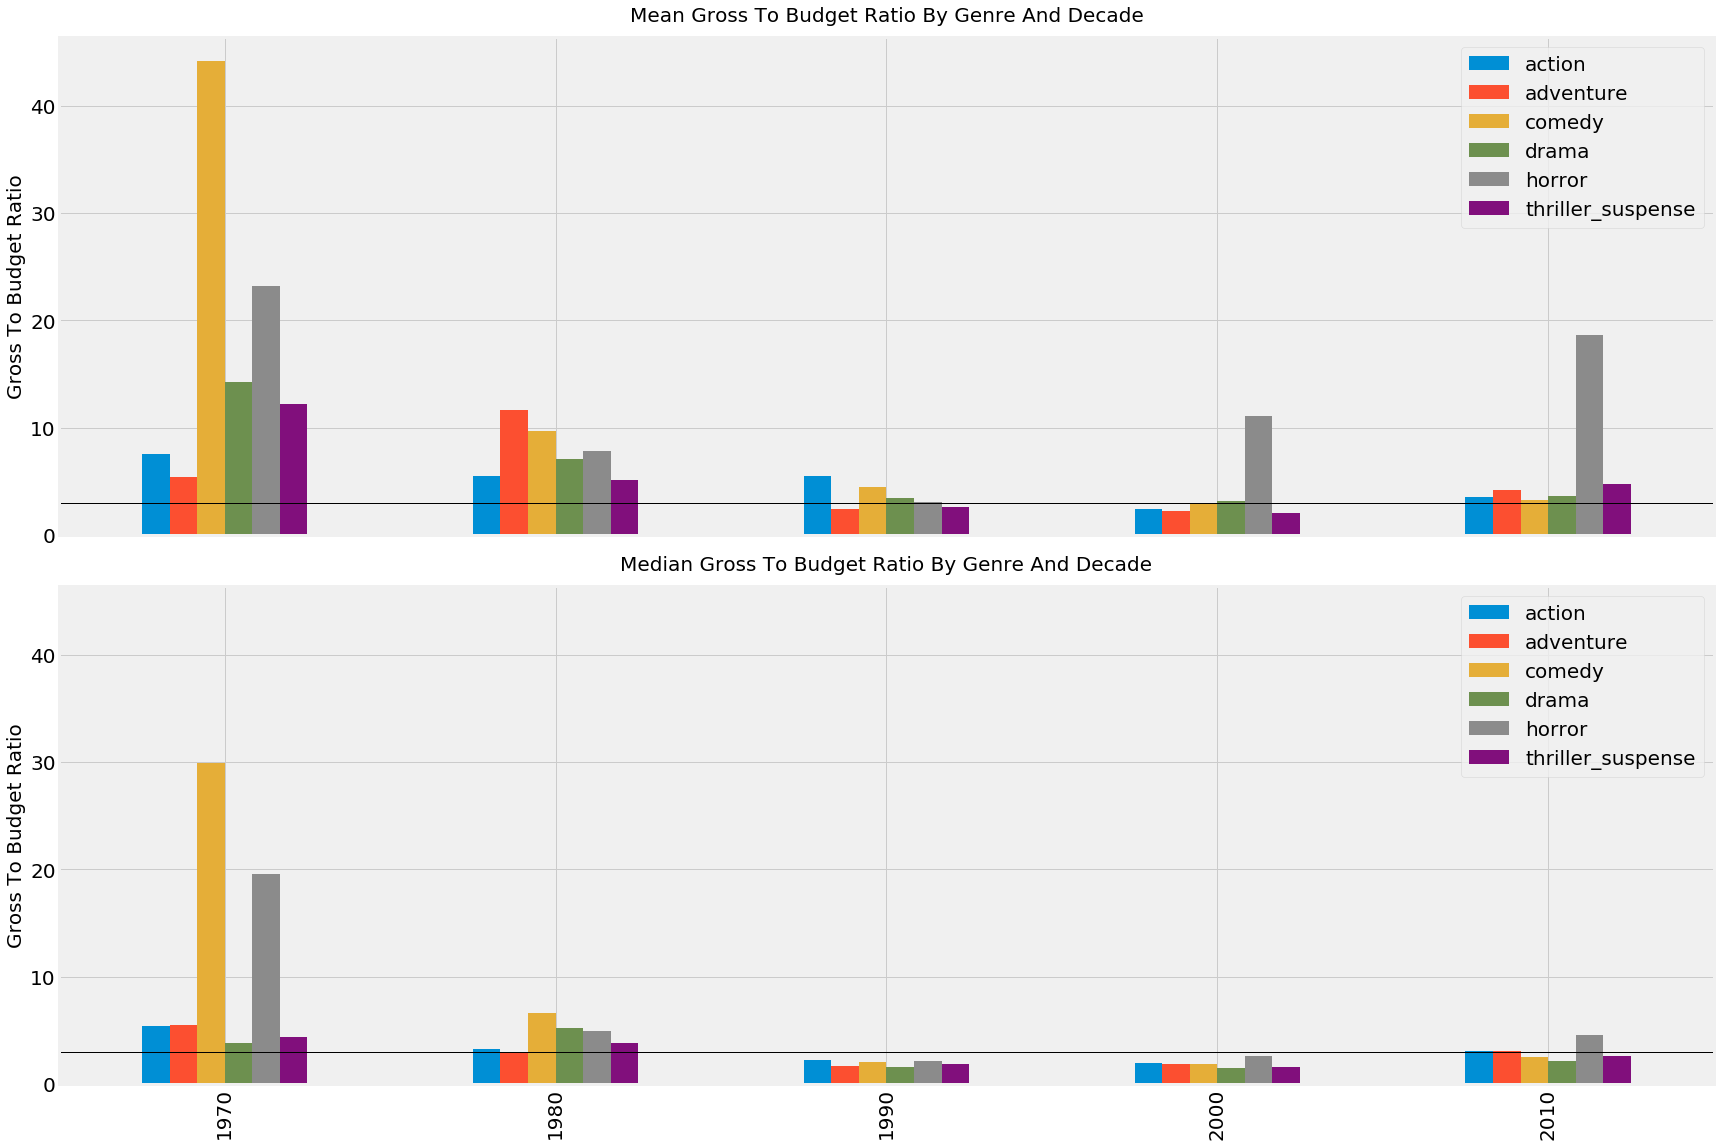

In [63]:
figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))

grp = data.groupby('release_decade')[gross_budget_ratio_columns].mean()
grp.plot(kind='bar', ax=axis1)
axis1.set_ylabel('Gross To Budget Ratio', fontsize=20)
axis1.set_xlabel('')
axis1.tick_params(labelsize=20)
axis1.legend(genres, fontsize=20)
axis1.set_title('Mean Gross To Budget Ratio By Genre And Decade', fontsize=20, y=1.02)
axis1.axhline(3, color='k', linewidth=1)

grp = data.groupby('release_decade')[gross_budget_ratio_columns].median() 
grp.plot(kind='bar', ax=axis2)
axis2.set_ylabel('Gross To Budget Ratio', fontsize=20)
axis2.set_xlabel('')
axis2.tick_params(labelsize=20)
axis2.legend(genres, fontsize=20)
axis2.set_title('Median Gross To Budget Ratio By Genre And Decade', fontsize=20, y=1.02)
axis2.axhline(3, color='k', linewidth=1)

plt.tight_layout()

## Quick Takeaways

The black line represents the point where a movie has grossed three times its production budget worldwide. It's our self-designated breakeven point.

The 1970s and 1980s are mostly above this breakeven point.

The 1990s and 2000s are entirely below this breakeven point.

The 2010s have three genres above this breakeven point: Horror, Action, and Adventure.

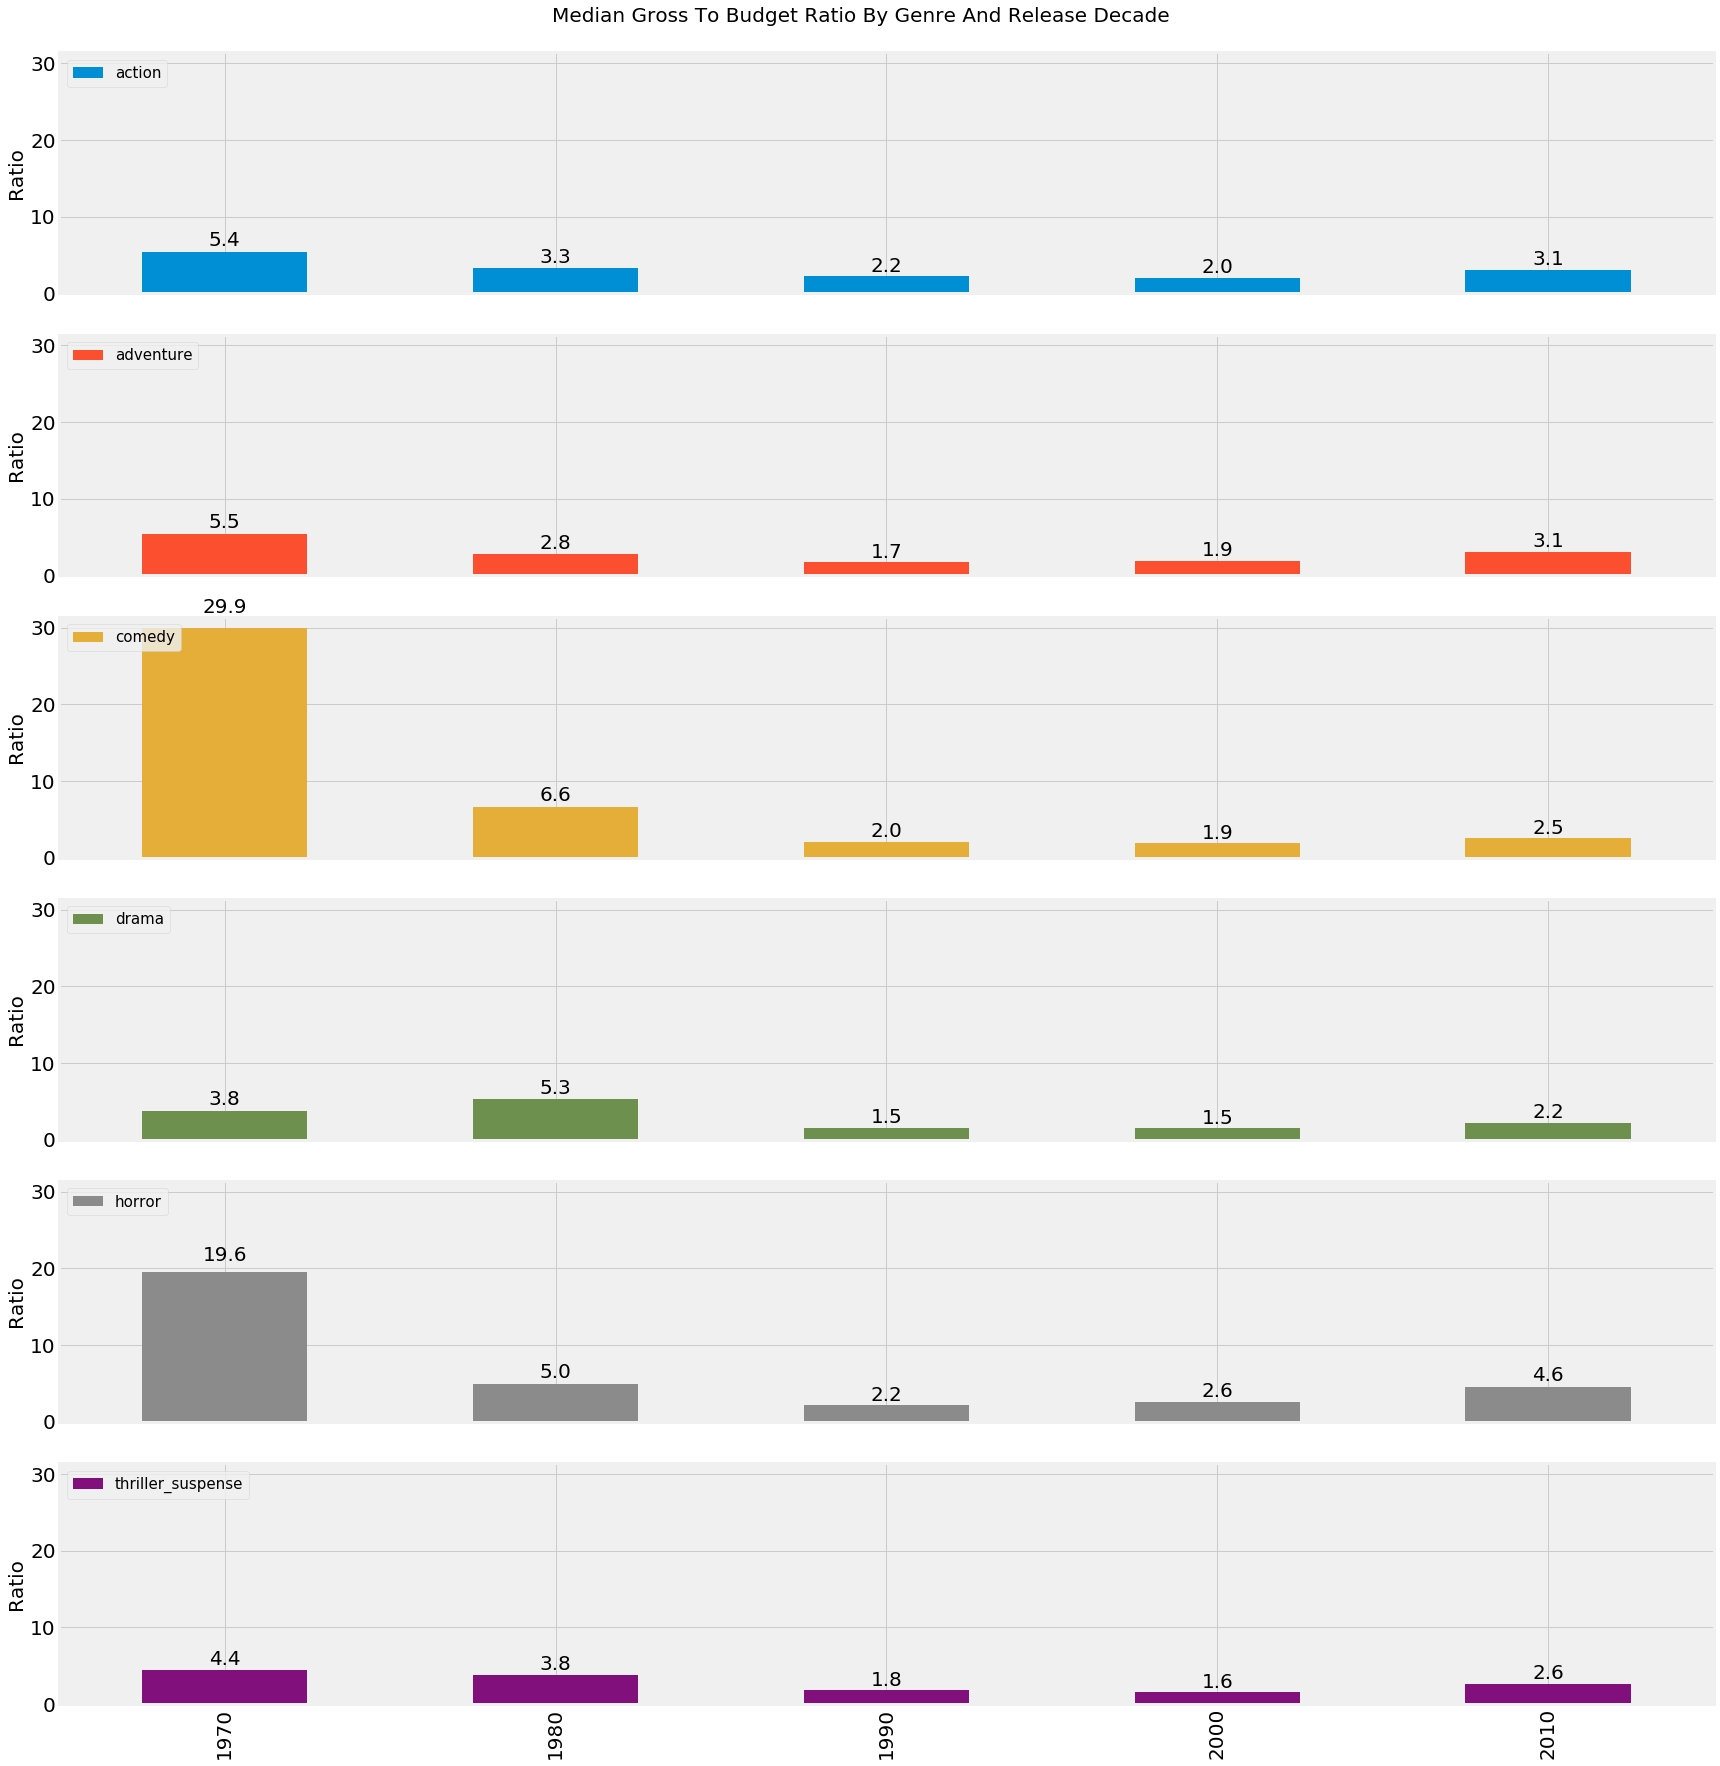

In [64]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 24))
figure.suptitle('Median Gross To Budget Ratio By Genre And Release Decade', fontsize=20, y=1.02)

#ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
#axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes.flat, colors):    
    # Create a series with decades as indexes and median budget as values
    grp = data[data[genre]].groupby('release_decade')['gross_budget_ratio'].median()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1970, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1970, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Ratio', fontsize=20)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)
    axis.tick_params(labelsize=20)
    axis.axhline(0, color='k', linewidth=1)
    autolabel(axis, num_decimals=1)

plt.tight_layout() 

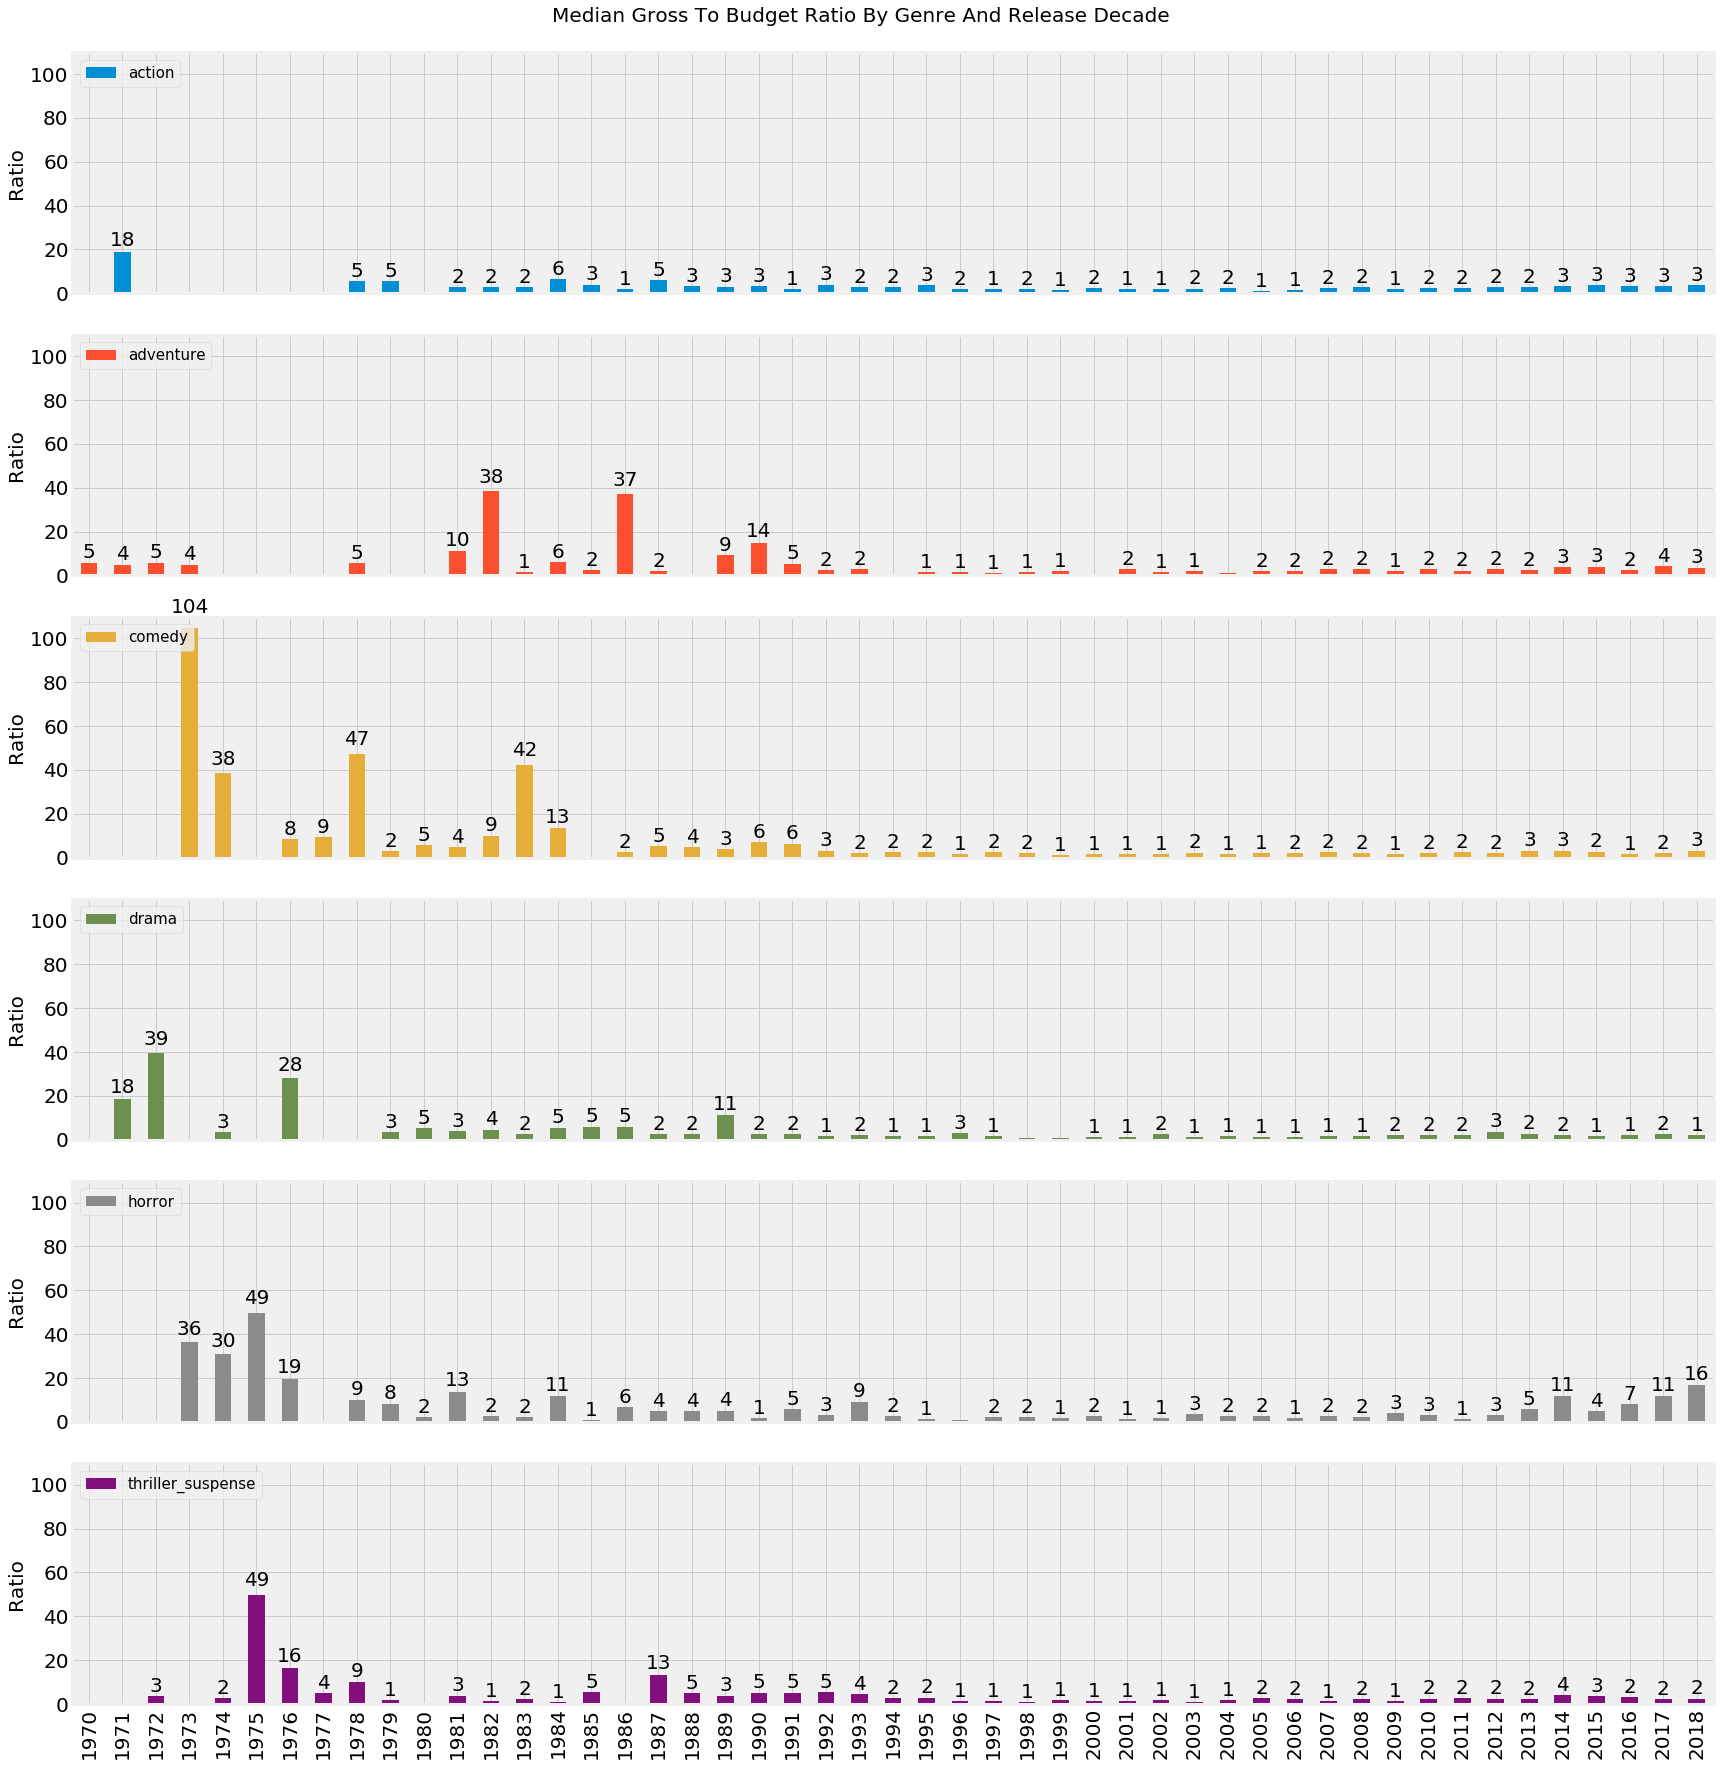

In [65]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 24))
figure.suptitle('Median Gross To Budget Ratio By Genre And Release Decade', fontsize=20, y=1.02)

#ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
#axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes.flat, colors):    
    # Create a series with decades as indexes and median budget as values
    grp = data[data[genre]].groupby('release_year')['gross_budget_ratio'].median()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for year in range(1970, 2019):
        if year not in grp.index:
            grp.loc[year] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1970, 2019), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Ratio', fontsize=20)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)
    axis.tick_params(labelsize=20)
    axis.axhline(0, color='k', linewidth=1)
    autolabel(axis)

plt.tight_layout() 

## Quick Takeaways

**Big movies in the 1970s and 1980s heavily skew the results**
  - We have fewer entries from the 1970s and 1980s. Some years are missing a movie from a genre or have only 1 movie in that genre.
  - For example Jaws is the only movie in our dataset from 1975. It also happened to be the first modern day blockbuster. With a worldwide gross to budget ratio of 49.5, you might think that 1975 was amazing for Horror and Thriller movies, but that result stems from one movie
  - Another example is 1973 only having three movies in our dataset. One of them is The Godfather. It's labeled as a Crime Drama and has a worldwide gross to budget ratio of 39.5. This movie alone is what is giving Drama such a huge value there.
  
**More recent movies are more reliable**
  - The data from more recent decades has more entries, so we can trust those results are far less likely to be heavily skewed by a few big movies.
    - Movies per decade:
      - 1970s: 31
      - 1980s: 114
      - 1990s: 501
      - 2000s: 1047
      - 2010s: 740
      
**Horror still the best current choice**
  - This decade, Horror earns a median 4.6 dollars theatrically for every dollar spent on production, which means the median Horror movie this decade is profitable. 
  - Action and Adventure both earn 3.1, making ever so slightly profitable. 
  - The other genres are median losers this decade.
  - These results mimic those using our profit calculation (as they should). We are using the same formula but looking at our dataset with a ratio of gross to budget as opposed to individually calculating profits for each movie.  

In [68]:
# Function to plot mean and median profitability by subgenre by decade
def subgenre_profitability_by_decade(genre, colors):
    subgenres = data[data[genre.lower()]].groupby('genres_mojo').count().index
    num_subgenres = len(subgenres)
    
    figure, axes = plt.subplots(nrows=num_subgenres, ncols=1, figsize=(24, 50), sharex=True)
    figure.suptitle('Mean and Median Profit By {} Subgenre And Decade'.format(genre.title()), fontsize=20, y=1.02)

    for subgenre, axis in zip(subgenres, axes.flat):
            grp = (data[data['genres_mojo'] == subgenre].groupby('release_decade').agg(['mean', 'median']) / 1000000)['profit'].copy()

            # If the series is missing a decade, add it as an index and set the value to zero
            for decade in range(1970, 2020, 10):
                if decade not in grp.index:
                    grp.loc[decade] = 0

            # Sort the series by its index to have the decades in chronological order                
            grp.sort_index(ascending=True, inplace=True)

            # Set up y-axis    
            grp.plot(kind='bar', xticks=range(1970, 2020, 10), color=colors, linewidth=3, ax=axis)

            axis.set_ylabel('Millions', fontsize=20)
            axis.set_title(subgenre, fontsize=20)
            axis.legend(['Mean', 'Median'], loc='lower left', fontsize=15)
            axis.set_xlabel('')
            axis.tick_params(labelsize=20)
            axis.axhline(0, color='k', linewidth=1)

            autolabel(axis)

    plt.tight_layout()

## Gross To Budget Ratio

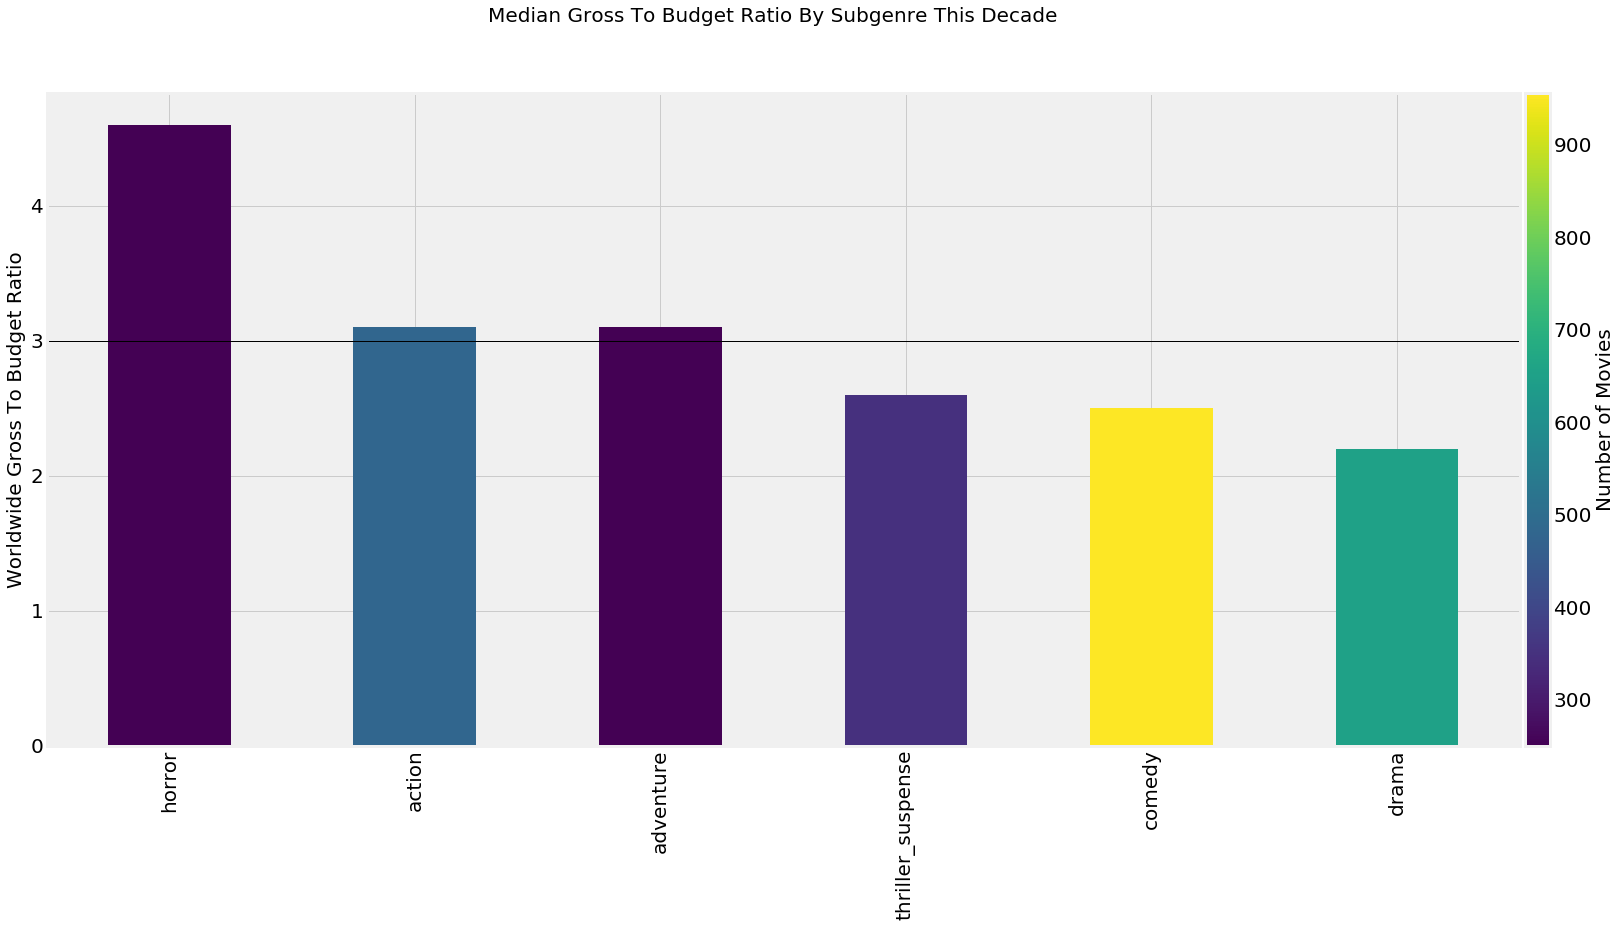

In [79]:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
# https://matplotlib.org/users/gridspec.html#gridspec-and-subplotspec

# Import colormap functionality from matplotlib
import matplotlib.cm as cm

# To scale our counts array from [0,1] create custom colormap
from sklearn.preprocessing import minmax_scale

figure = plt.figure(figsize=(24,12))
figure.suptitle('Median Gross To Budget Ratio By Subgenre This Decade', fontsize=20)

gs = matplotlib.gridspec.GridSpec(50, 50)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1:])


summary.sort_values(by='current_decade_median_gross_budget_ratio', ascending=False, inplace=True)
counts = [data[genre].sum() for genre in summary.index]

# Use 'viridis' colormap
viridis = cm.get_cmap('viridis')

# Normalize our counts series
scaled_counts = minmax_scale(counts, feature_range=(0,1))

# List of colors using rescaled count values
new_cmap = [viridis(item) for item in scaled_counts]

summary['current_decade_median_gross_budget_ratio'].plot(kind='bar', ax=ax1, color=new_cmap)

norm = matplotlib.colors.Normalize(vmin=min(counts), vmax=max(counts))

cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
ax2.set_ylabel('Number of Movies', fontsize=20)
ax2.tick_params(labelsize=20)
ax1.set_xlabel('')
ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
ax1.tick_params(labelsize=20)
ax1.axhline(3, color='k', linewidth=1);

## Quick Takeaways

Horror, Action, and Adventure are the only genres that are median winners this decade, even though they are three of the four least produced genres.

Interestingly, the two most produced genres this decade, Comedy and Drama, are the biggest median losers.

## Breakdown By Budget

It might help to further subdivide our genres by their budgets to look for patterns there.

In [80]:
bins = [0, 1000000, 5000000, 10000000, 25000000, 50000000, 100000000, 200000000, 300000000, 400000000]
group_names = ['0 - 1m', '1 - 5m', '5 - 10m', '10 - 25m', '25 - 50m', '50 - 100m', '100 - 200m', '200 - 300m', '300 - 400m']
ten_colors = ['#8d6a9f', '#006494', '#fcfc62', '#dda448', '#bb342f', '#435058', '#e56399', '#8cbcb9', '#57886c', '#f1f2ee']

data['budget_bins'] = pd.cut(data['budget_adj'], bins, labels=group_names)

In [81]:
def gross_to_budget_ratios_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Gross To Budget Ratio For {} This Decade\n(Number of Movies Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    grp['median'].plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(3, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1, counts=grp['count'])

In [82]:
def profit_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit For {} This Decade\n(Profit Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['profit'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(0, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1)

In [149]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to highlight positive numbers green and negative numbers red
def background_color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'background-color: red'` for negative
    strings, black otherwise.
    """
    bg_color = '#fc4f30' if val < 0 else 'green'
    return 'background-color: {}'.format(bg_color)

In [84]:
# Define custom function to output median profits by subgenre for current decade
def median_profit_by_subgenre_current_decade(genre):
    figure = plt.figure(figsize=(24,12))
    figure.suptitle('Median Profit By {} Subgenres This Decade'.format(genre), fontsize=20)

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    grp = data[(data['genres_mojo'].str.contains(genre, regex=True)) & (data['release_year'] >= 2010)].groupby('genres_mojo')['profit'].agg(['median', 'count']).sort_values(by='median', ascending=False)

    # Use 'viridis' colormap
    viridis = cm.get_cmap('viridis')

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [viridis(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap)

    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
    ax2.set_ylabel('Number of Movies', fontsize=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)

## Action

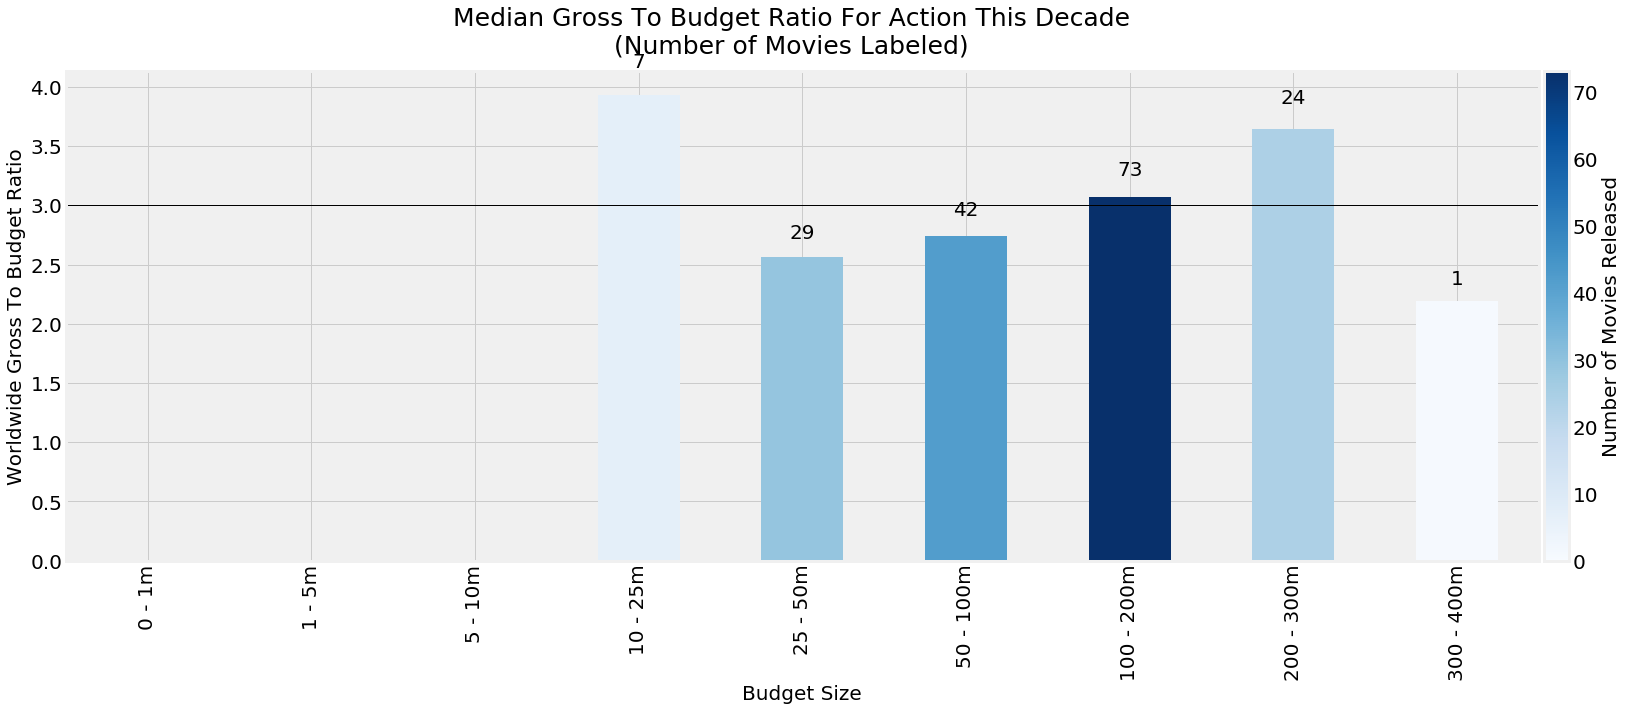

In [85]:
gross_to_budget_ratios_by_genre_this_decade('action', genres_dict['action']['colormap'])

<div class="alert alert-block alert-info">
    <b>Due to the sheer size of some movie budgets, a lower budgeted movie can earn more multiples of its own budget and still end up earning less than a movie with a higher budget and a lower earnings multiple.</b>
    <br>
    <br>
    <b>We should look at both ratio stats and direct dollar-value stats for the big picture.</b>
</div>

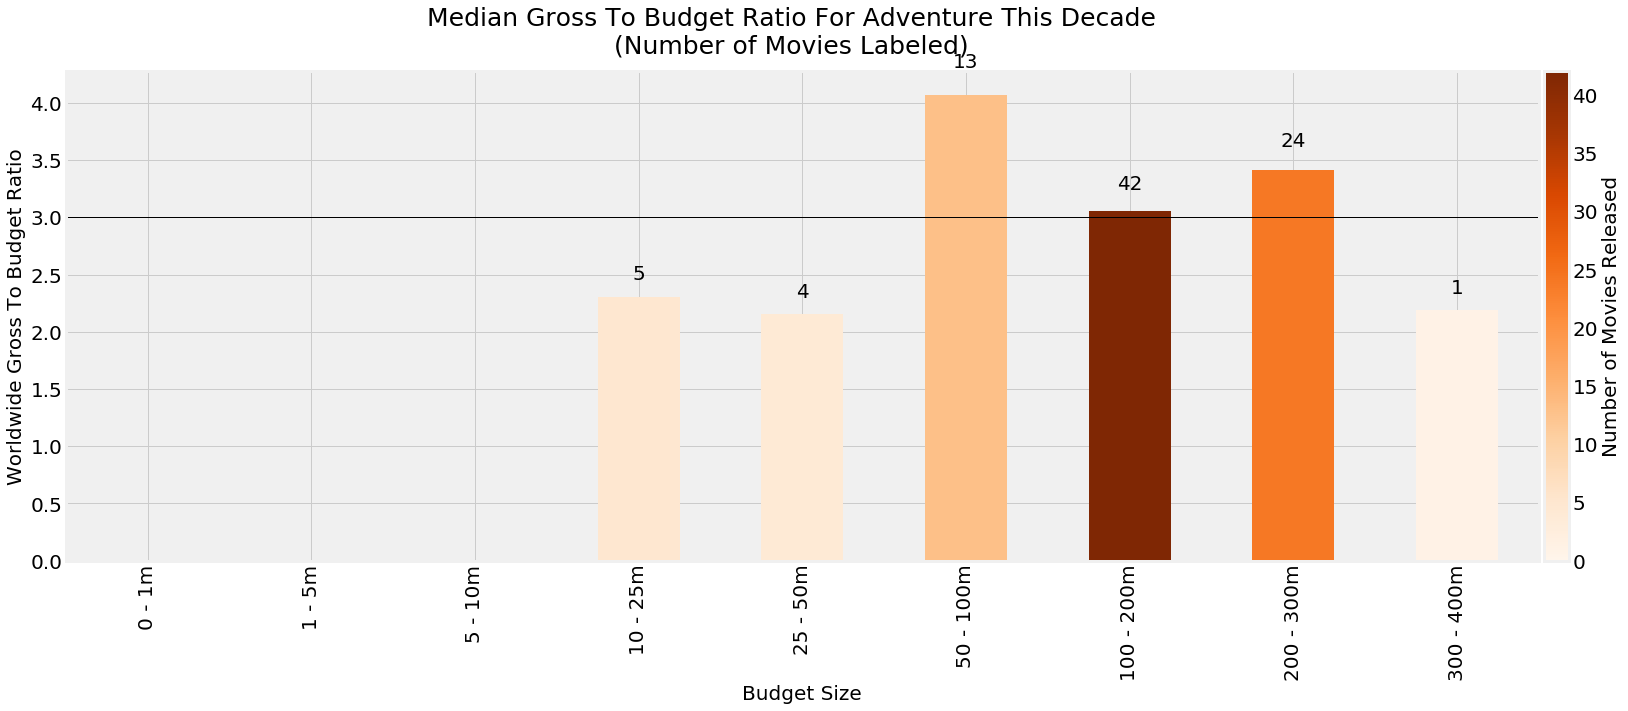

In [89]:
gross_to_budget_ratios_by_genre_this_decade('adventure', genres_dict['adventure']['colormap'])

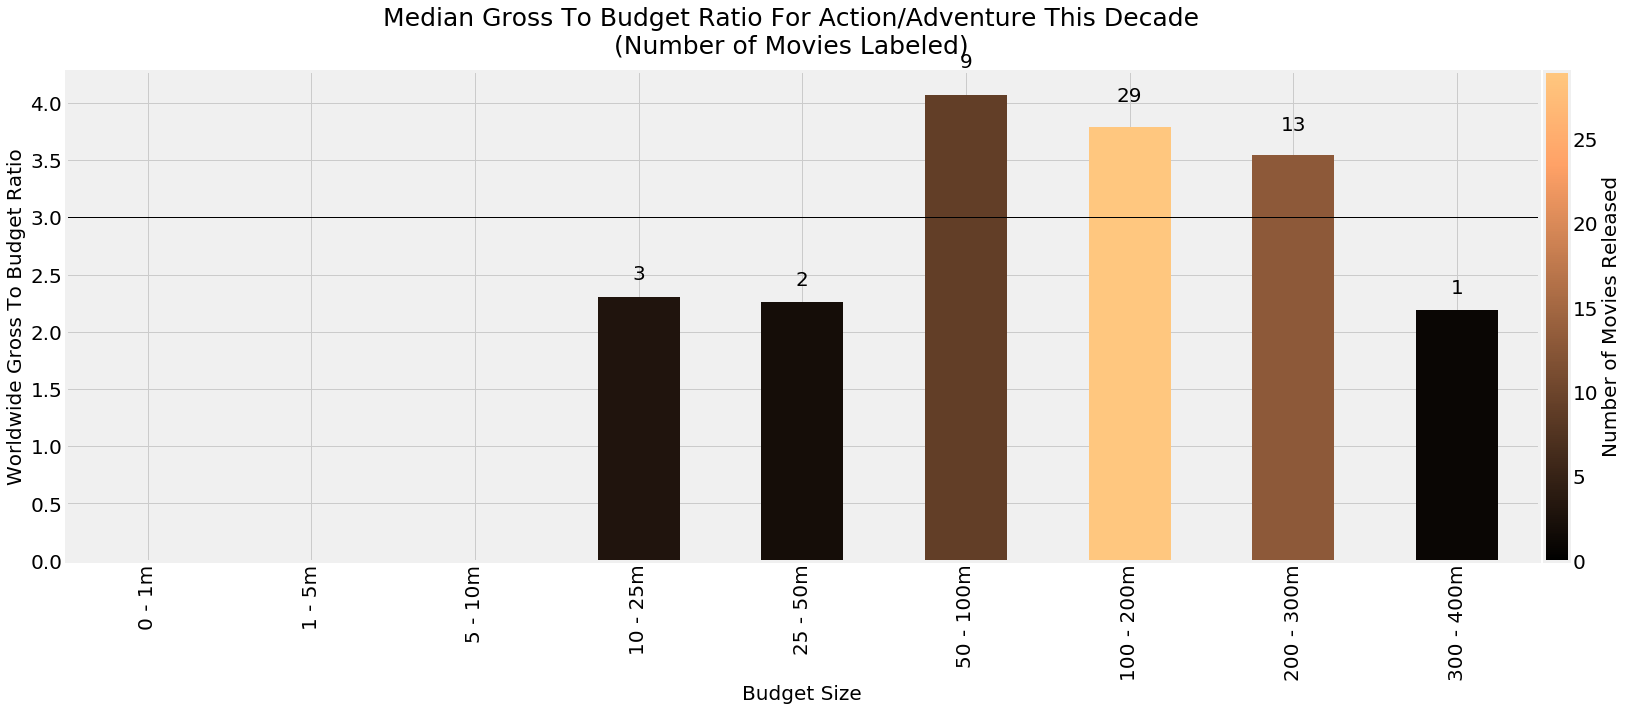

In [93]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Gross To Budget Ratio For Action/Adventure This Decade\n(Number of Movies Labeled)', fontsize=25)

grp = data[(data['genres_mojo'].str.contains('Action / Adventure')) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

gs = matplotlib.gridspec.GridSpec(50, 50)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1:])

# Assign colormap
cmap = cm.get_cmap('copper')

# Normalize our counts series
scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

# List of colors using rescaled count values
new_cmap = [cmap(item) for item in scaled_counts]

grp['median'].plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

# Normalize the colorbar by genre counts
norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
#cb1.set_label('Number of Movies')
    
ax1.set_xlabel('Budget Size', fontsize=20)
ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
ax1.tick_params(labelsize=20)
ax1.axhline(3, color='k', linewidth=1)
    
ax2.set_ylabel('Number of Movies Released', fontsize=20)
ax2.tick_params(labelsize=20)
autolabel(ax1, counts=grp['count'])

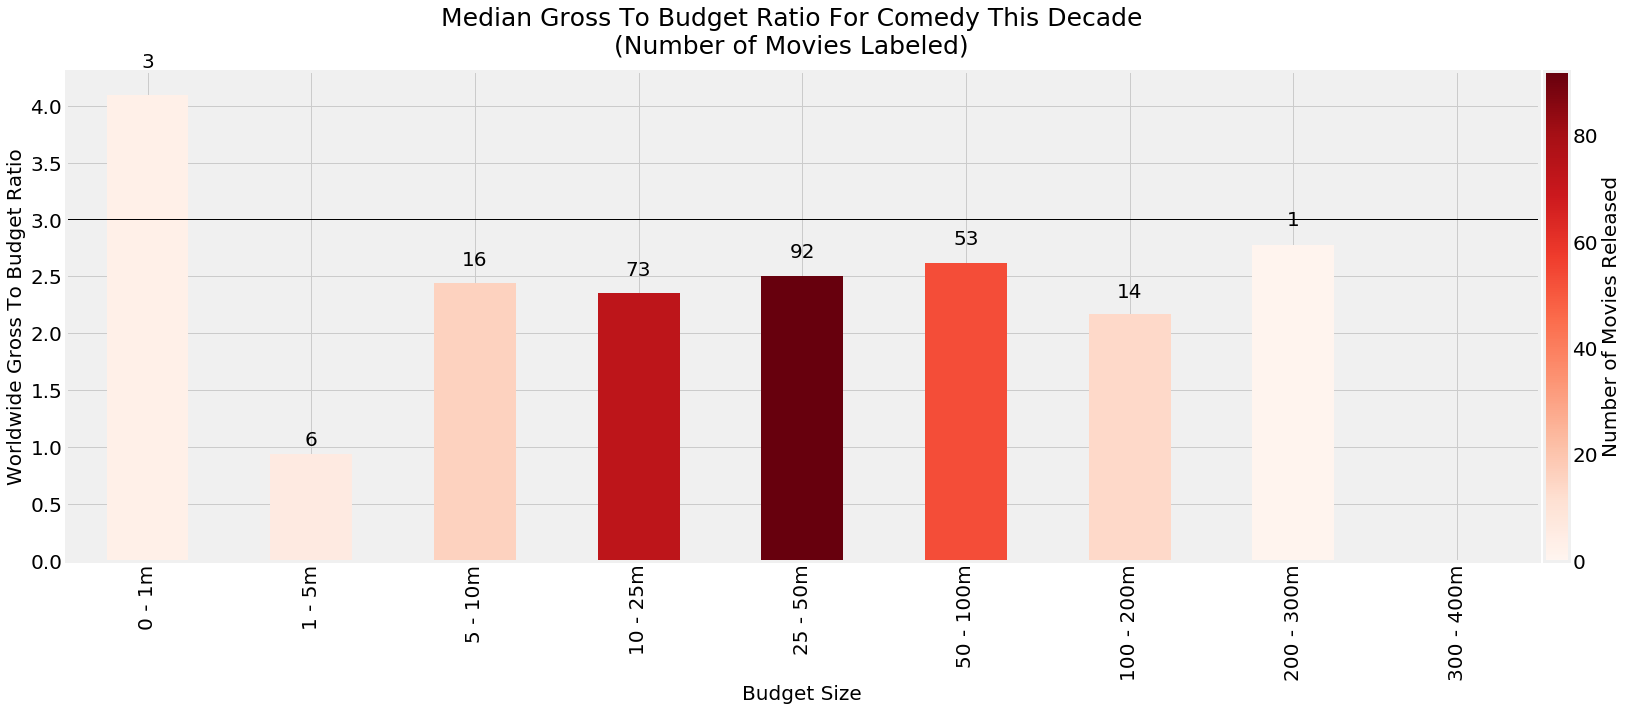

In [96]:
gross_to_budget_ratios_by_genre_this_decade('comedy', genres_dict['comedy']['colormap'])

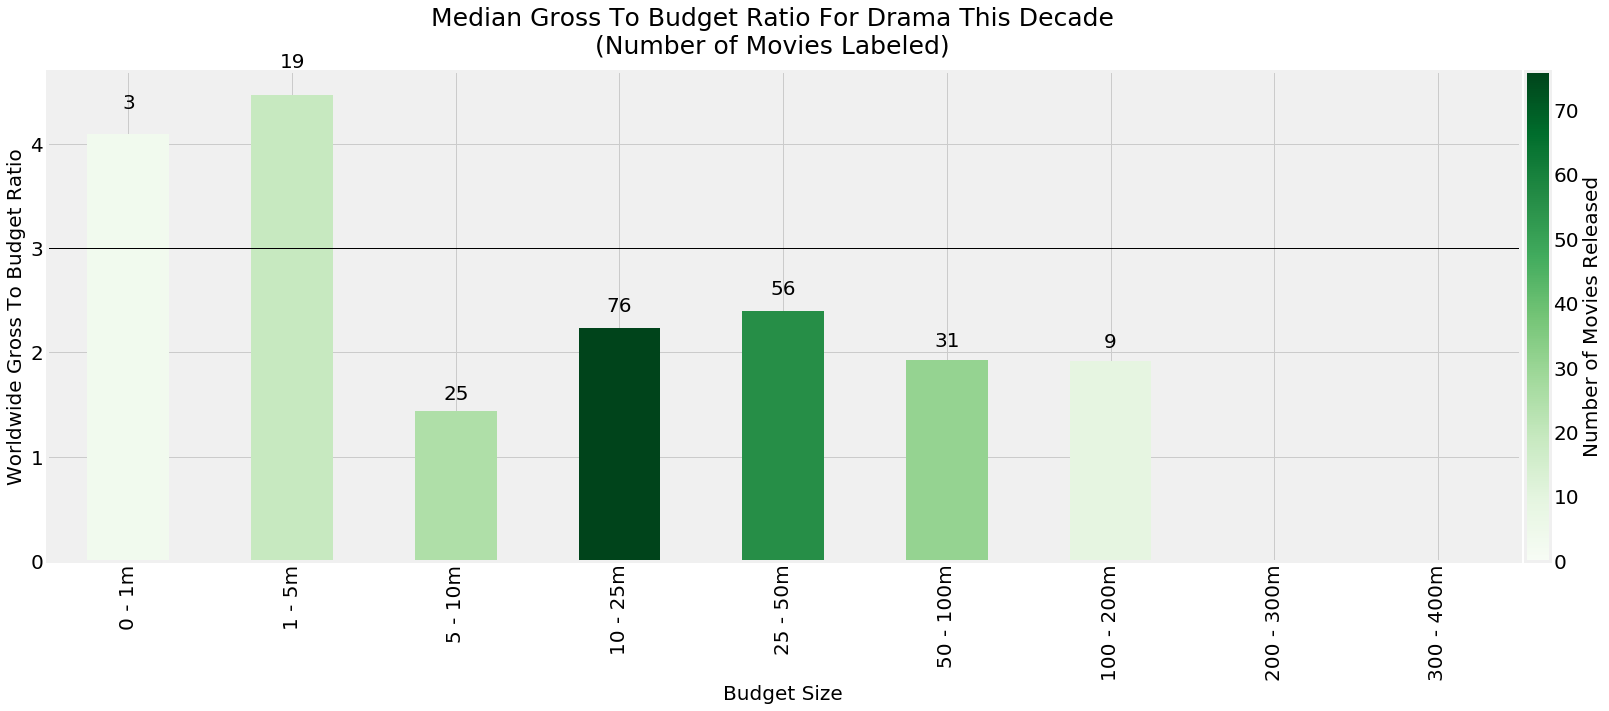

In [100]:
gross_to_budget_ratios_by_genre_this_decade('drama', genres_dict['drama']['colormap'])

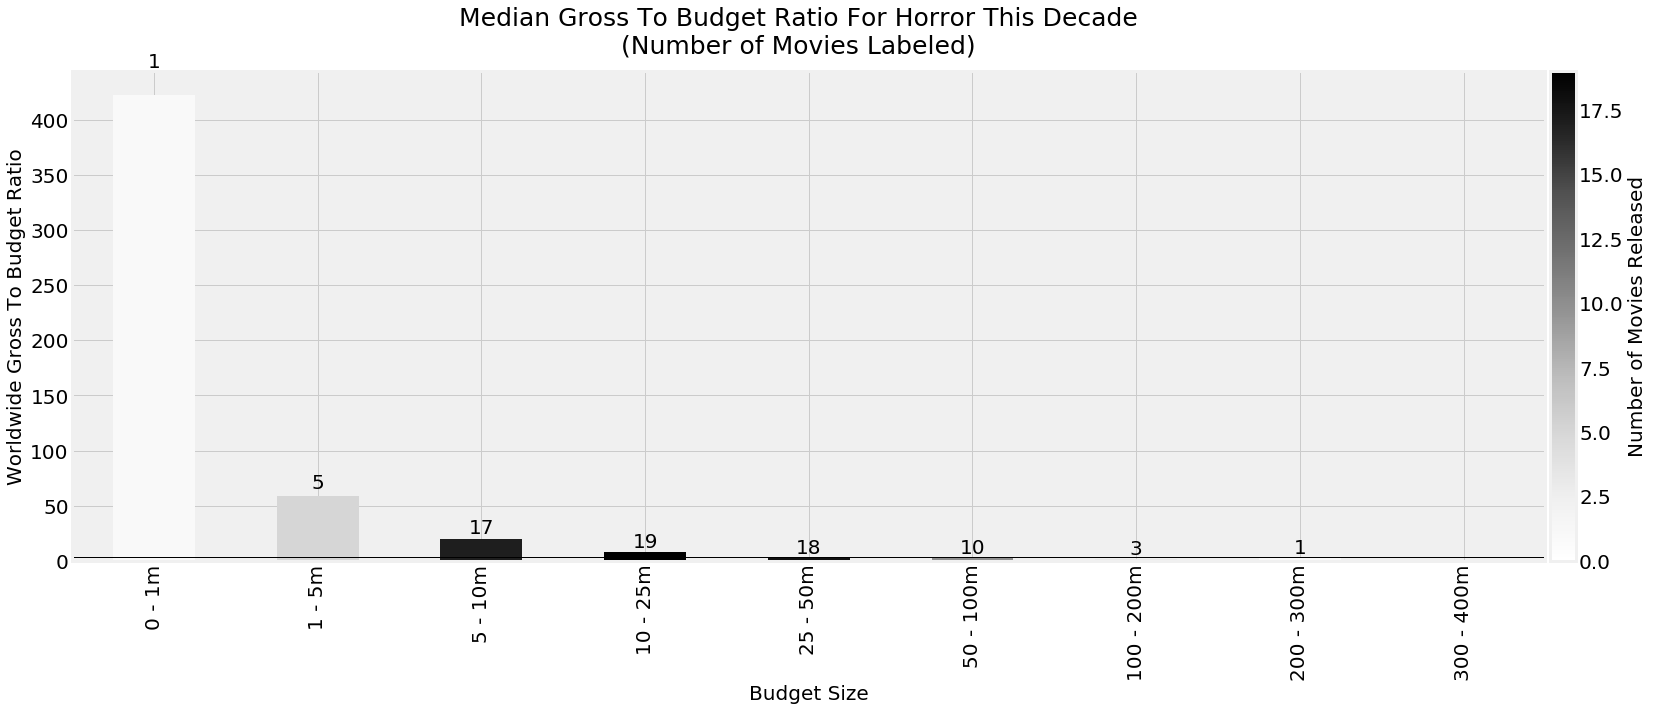

In [104]:
gross_to_budget_ratios_by_genre_this_decade('horror', genres_dict['horror']['colormap'])

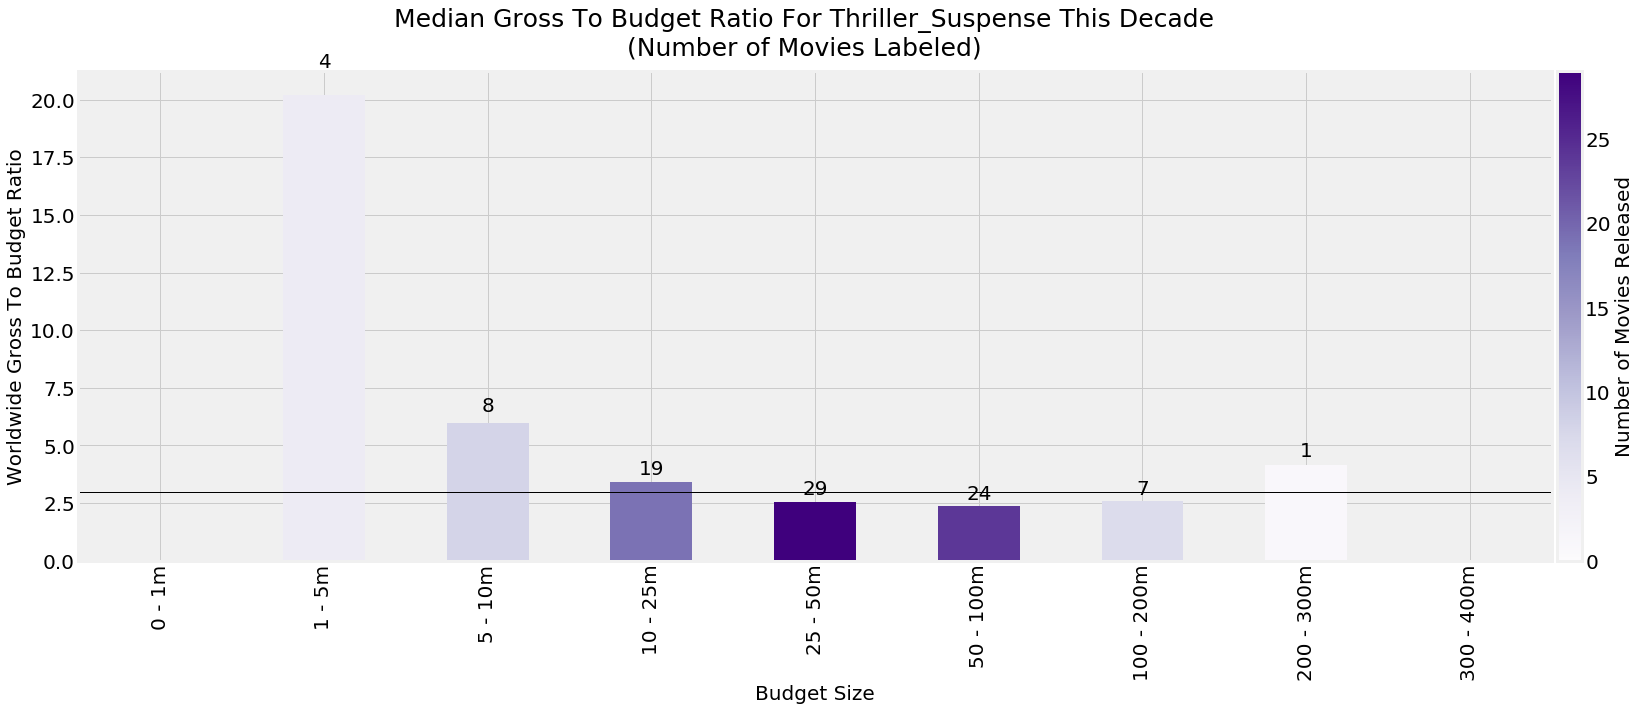

In [108]:
gross_to_budget_ratios_by_genre_this_decade('thriller_suspense', genres_dict['thriller_suspense']['colormap'])

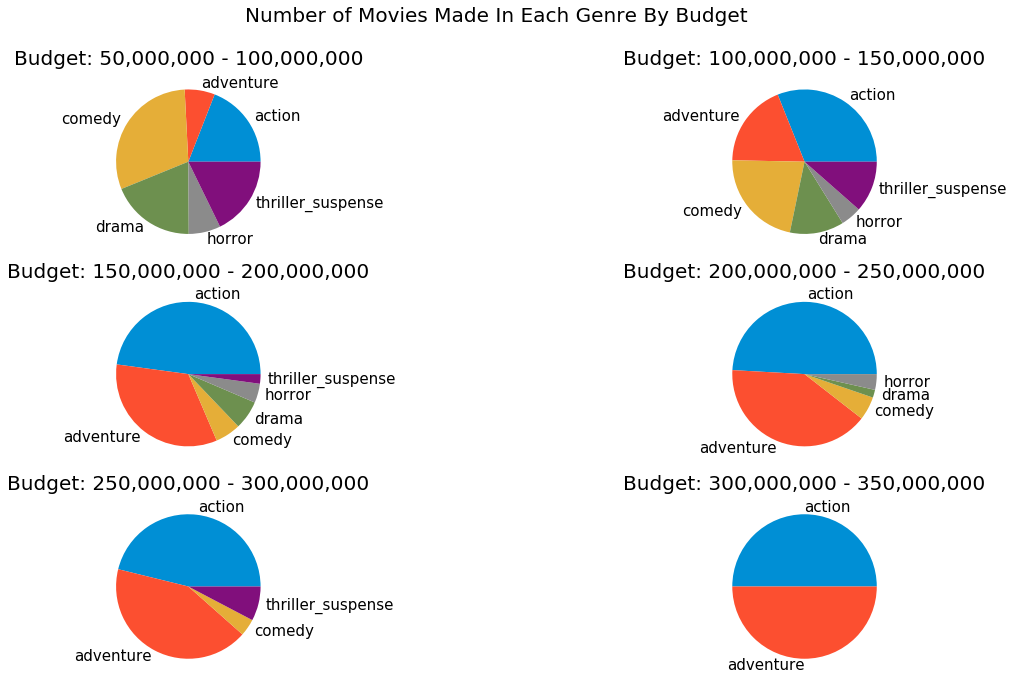

In [124]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies Made In Each Genre By Budget', fontsize=20, y=1.05)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

budgets = range(50000000, 350000000, 50000000)

for budget, axis in zip(budgets, axes_list):
    data[(data['budget_adj'] >= 0 + budget) & (data['budget_adj'] < 50000000 + budget)][genres].sum().plot(kind='pie', ax=axis, fontsize=15)
    axis.set_ylabel('')
    axis.set_title('Budget: {:,} - {:,}'.format(0 + budget, 50000000 + budget), fontsize=20)
    
plt.tight_layout()

NameError: name 'worldwide_columns' is not defined

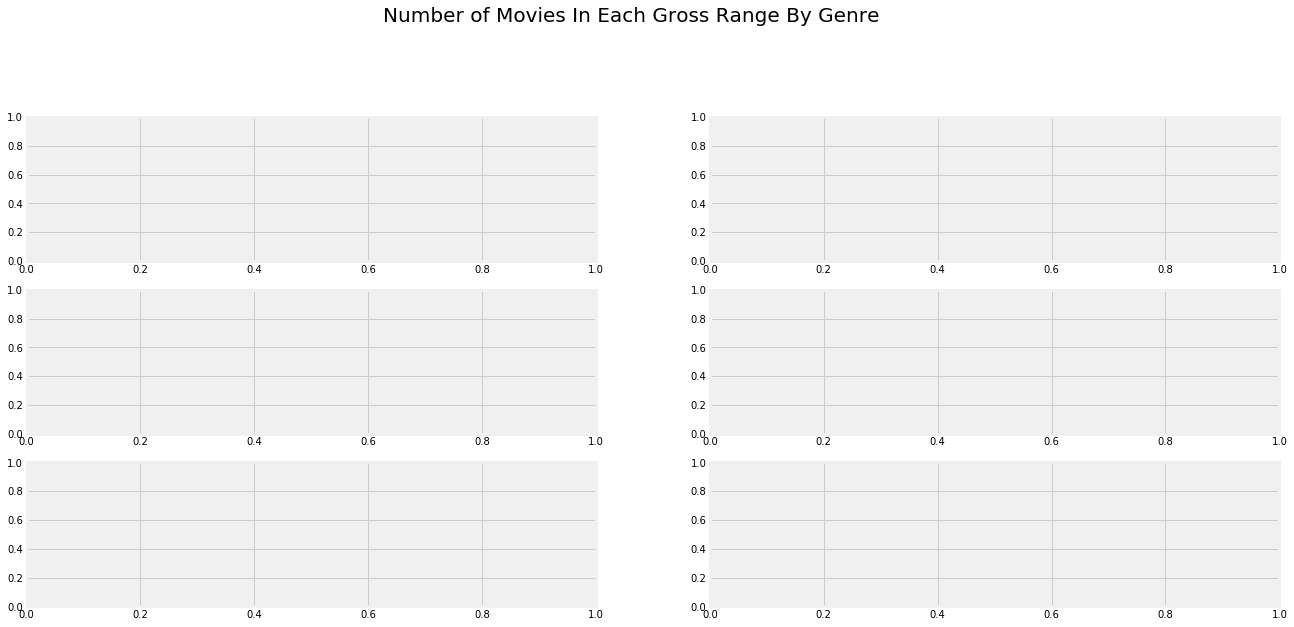

In [125]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies In Each Gross Range By Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000)][worldwide_columns].count().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

In [1]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000) & (data['release_year'] >= 2010)][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Ratio of Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

decades = range(1960, 2020, 10)

for decade, axis in zip(decades, axes_list):
    data[data['release_decade'] == decade][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('{}s'.format(decade), fontsize=20)
    
plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,40))
figure.suptitle('Ratio Versus Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes.flatten()
axes_list1 = [ax1, ax3, ax5, ax7, ax9, ax11]
axes_list2 = [ax2, ax4, ax6, ax8, ax10, ax12]

decades = range(1960, 2020, 10)

for decade, axis1, axis2 in zip(decades, axes_list1, axes_list2):
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='pie', ax=axis1, fontsize=12, labels=genres)
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='bar', ax=axis2, fontsize=12, ylim=(0,80))
    axis1.set_ylabel('')
    axis1.set_title('{}s Ratios'.format(decade), fontsize=20)
    axis2.set_xticklabels(genres)
    axis2.set_title('{}s Totals'.format(decade), fontsize=20)
    axis2.set_ylabel('Billions', fontsize=20)
plt.tight_layout()

In [ ]:
# We want individual columns that hold the worldwide gross for each genre
# Since a movie can have multiple genres, right now we must handle this by a groupby while looping over each genre
# If we create individual columns that contain information about a genre and its worldwide box office, it's easier to graph
def worldwide_gross_by_genre(row, genre):
    # Returns either 0 or the `worldwide_adj` value due to boolean multiplication
    test = row[genre] * row['worldwide_adj']
    
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# List of new columns to hold worldwide grosses by genre
worldwide_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, worldwide_columns):
    data[col] = data.apply(lambda x: worldwide_gross_by_genre(x, genre), axis=1)

### Quick Takeaways

**All-Time Gross Per Genre**
  - In aggregate, `Action`, `Comedy`, then `Adventure` have grossed the most money worldwide
  - `Action` is ahead of `Comedy` by almost \\$16 billion dollars
  
**Recent Trends**
  - Grosses for `Action` and `Adventure` have been increasing since the 1990s
  - Grosses for `Comedy` have substantially decreased in the 2010s, but it is still the third-highest performing genre
  - Grosses for the other genres are all in decline

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Dollars Earned For Every Dollar Spent (Includes Marketing)', fontsize=20, y=1.02)

summary.sort_values('dollars_earned_for_dollars_spent', ascending=False, inplace=True)

summary.plot(y=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], kind='bar', ax=axis, color=colors[0:3], legend=True)
axis.set_ylabel('Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['All-Time', 'Mean', 'Median'], fontsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

# What We Know So Far

**Dataset limitations**
  - Our data only contains entries from the Big Five studios that have both Worldwide Gross information and Budget information.
  - We chose to limit our entries to movies by the Big Five to control for lack of promotion or budget hindering a film's chances. 
  - As such, there are obviously many movies that are missing from our analyais. 
  - Hopefully, the overall pattern of movie returns is captured in the data we have, but we very easily could have a misrepresentative sample.
  
**Number of movies**
  - `Comedy` and `Drama` are historically the most produced genres by big movie studios by a healthy margin

**Skewed grosses**
  - Worldwide gross is heavily right-skewed. 
  - It has a much higher median than mean (almost double!)
  - This fits with our understanding of the movie business -- there are a few megahits that earn outsized returns while the majority of movies earn a little or even lose money
  
**Skewed budgets**
  - Budgets are also heavily right-skewed, but with a much shorter right-tail than worldwide gross
  - This also fits our understanding of the movie business -- most movies are made for relatively small budgets, and there are only a few blockbusters made that have very large budgets
  
**Skewed profits**
  - Profits are also skewed to the right.
  - It's interesting that both mean and median profits are negative. Movies are indeed not a slam-dunk investment.
  
**Use median**
  - We will err on the side of using the median for our summary statistic. Our bosses are looking for insight into what they can expect as an average return from a movie they produce. We'd all like to have the mega blockbusters, but to keep their expectations in check, we will report a more fair assessment of our prospects.

**Highest gross**
  - Action, Comedy, and Adventure have grossed the most money. 
  
**Profitability**
  - Horror, Adventure, and Action are the only genres that are net winners.
  
**Median profit**
  - No genre is a net winner in terms of median profit
  
**Mean profit**
  - Horror has the biggest boost from the right skew in terms of mean profitability.
  - Adventure and Action also go from net losers to net winners when looking at mean profits.
  
**Thoughts**
  - We are going to dig way deeper, but it's nice to get a sense of the overall big picture by genre.

**Far from a sure thing**
  - Using our formula where profits begin after grossing three times the budget, we see that there are no clear and obvious genres to invest in.
  - It seems like the success or failure of a movie probably stems from the individual circumstances of each movie rather than solely from its categorization.

**All-Time Gross Per Genre**
  - In aggregate, Action, Comedy, then Adventure have grossed the most money worldwide
  - Action is ahead of Comedy by almost \\$16 billion dollars

**Skewed dataset**
  - Our dataset with respect to budget and gross is heavily skewed to the right. We can see we have much higher mean grosses than median grosses. This fits with our understanding of the movie business as a whole where very few blockbusters make up the slack for the more numerous smaller budgeted movies studios release. 

**Skew**
  - Even subdivided by genre, the gross distributions are all right-skewed.
  
**Mean and median**
  - Mean and median gross for Adventure and Action are far higher than any other genre
  - Adventure's median gross is approximately 2.6 times as large as the third place median gross, Horror.
  - The most common gross amount in every genre except Adventure is $0 - \\$50 milllion
  
**Action/Adventure**
  - These two genres have the biggest spread between mean and median gross
  - Something to keep in mind is the frequency of movies labeled as Action/Adventure. In our analysis, such movies would count towards both Action and Adventure movies. (We are assigning movies to every genre they have.) 
  - Since both of these genres are big on spectacle, they tend to be more likely to be blockbuster material 
  - We might have a situation where duplicate entries in both columns are artificially boosting their totals
  - Let's investigate this a little further  
  
**Number of movies**
  - Comedy and Drama are historically the most produced genres by big movie studios by a healthy margin
  
**Gross**
  - Adventure and Action have the highest median gross
  - Adventure's median gross is approximatley 2.7 times the third place genre's, Horror
  
**Budget**
  - Adventure and Action have by far the largest median production budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Both Adventure and Action are at least double the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median budgets 
  
**Median production budget**
  - Adventure and Action have by far the largest median budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Adventure is 2.3 times the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median production budgets 
  - Production budgets are also right-skewed, but they have far less skew than worldwide grosses
  
**Low budgets**
  - We can tell by the median production budget of 41.2 million that the majority of movies produced have a relatively small budget
  - Blockbusters (those costing 200-300 million dollars) are the exception, rather than the rule
  - Something to keep in mind is if this trend has changed in the past decade

**Movies are a tough business**
  - Just looking at the aggregate movie data we have, it seems like almost no genre is a safe bet.
  - No genre (when including all its subgenres) has a positive median profitability.
  - The only subgenres with a positive median profit are (in descending order) Foreign/Action, Action/Adventure, Horror, and Music Drama.

**The skew strongly affects the results**
  - If we look at mean profits instead of median, the results are much different.
  - Horror, Adventure, and Action are all profitable on the genre level
  - In addition, many more subgenres are profitable in aggregate
  - This is the result of very high-earning movies drastically increasing the average return of other members of their subgenre.
  
**Same pattern when looking at median versus mean profits**
  - When directly using every single datapoint (`all-time` and `mean`), both Horror and Adventure are profitable in aggregate.
  - However, when using only the median results, Horror is breakeven and all other genres lose money.
  - This is evidence of the power of those long right tails in blockbusters' earnings.
  
**Less than 50%**
  - No genre has a better than 50% chance of breaking even.
  - The least risky one just from a breakeven perpective is Horror.
  - The next least risky movies are Action and Adventure.
    
## If A Decision Must Be Made Now

This would be a difficult decision to make. 

Action, Comedy, and Adventure have made the most overall money worldwide. Action and Adventure have far higher median worldwide grosses than Comedy. Comedy must be making up for this with its higher numbers of movies released. However, Adventure and Action are the two most expensive genres to make, whereas Comedy is fourth.

The highest aggregate return for every dollar spent comes from Horror, then Adventure.

The highest median profit per genre is Horror, then Comedy.

The genres with the three lowest median budgets are Drama, then Horror, then Comedy.

Movies have the best chance to breakeven in Horror, then Action, then Adventure.





When taking into account our domestic box office analysis, now we see the reason `Action` and `Adventure` movies are made. They were net losers domestically, but make up for this with much higher worldwide grosses. 
- `Action`:
  - Average domestic gross: \\$116 million
  - Average worldwide gross: \\$297 million

- `Adventure`:
  - Average domestic gross: \\$151 million
  - Average worldwide gross: \\$387 million

That's a difference of \\$181 million and \\$236 million respectively!  

There are a couple strategies our bosses can consider:

1) Go for the safest genre. Our bosses are less likely to lose big money on `Horror`. It's one the cheapest genres to produce and has the highest average dollar earned per dollar spent.

2) Swing for the fences. If they can afford to be risky, `Adventure` and `Action` historically have the highest earnings potential. This is probably due to their ability to travel well and be unimpeded by language barriers. Anyone in the world can watch a fight scene, car chase, or explosion and understand what's happening. 

Let's look at each genre's performance by decade to see if there are recent trends we can spot.

  - We will investigate genres by Release Decade and Release Week to look for more useful insights.

In [ ]:
# Create variables for first_axes, secondary_axes, and counter variables 
ax1, ax2, ax3, ax4, ax5, ax6 = 'abcdef'
first_axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1 = 'abcdef'
second_axes_list = [ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1]

# Counters to keep track of iteration
counters = [0, 1, 2, 3, 4, 5]

for genre, first_axis, second_axis, color, count in zip(genres, first_axes_list, second_axes_list, colors, counters):
        figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
        second_axis = figure.add_axes()

        # Only write the title once
        if count == 0:
            figure.suptitle('Median Worldwide Gross By Genre And Decade\n(Counts Labeled)', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').median() / 1000000)['worldwide_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel('Worldwide Gross In Millions', fontsize=12)
        first_axis.set_ylim(0,900)
        first_axis.legend([genre], loc=2, fontsize=15)
        
        autolabel(first_axis, counts=grp_counts.values)
        
        # Set up second y-axis
        second_axis = first_axis.twinx()
        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.set_ylim(0,600)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        # Only show graphs when on the last one
        if count == len(counters) - 1:
            plt.tight_layout()

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Decade and Genre', fontsize=20, y=1.02)

grp = data.groupby('release_decade')['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense'].sum()

grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Number of Movies', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

plt.tight_layout()

### Only Looking At Movies With A Production Budget

In [ ]:
has_budget = data[data['budget_adj'].notna()].copy()
has_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

**Recent data is more reliable**
  - We don't have many movies before the 1970s, so drawing conclusions there seems risky. For example, the huge spike in `Horror` in 1950 is due to a single movie.
  - We should be able to trust the more recent data as there are far more movies available.
  
**Last three decades**
  - `Horror`, `Comedy`, and `Drama` are the best dollar for dollar movies.

# Extras

In [ ]:
# Create worldwide gross by genre columns
def breakeven_by_genre(row, genre):
    if row[genre] is False:
        return np.nan
    
    if row['worldwide_breakeven'] is False:
        return 0
    else:
        return 1
    
# List of new columns to hold worldwide grosses by genre
breakeven_columns = ['breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: breakeven_by_genre(x, genre), axis=1)

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    # Create two series with decades as indexes and count and sum as values
    
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['worldwide_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['worldwide_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
        
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Aggregate Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    # Create two series with decades as indexes and sum as values
    grp_gross_sum = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('release_year')['worldwide_adj'].sum().copy()
    grp_budget_sum = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the sum to 0
    for year in range(2010, 2019, 1):
        if year not in grp_gross_sum.index:
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_sum.index:
            grp_budget_sum.loc[year] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Profit Versus Current Decade Profit', fontsize=20, y=1.02)

summary.sort_values('all_time_profit', ascending=False, inplace=True)

summary.plot(y=['all_time_profit', 'current_decade_profit'], kind='bar', ax=axis)
axis.set_ylabel('Millions', fontsize=20)
axis.set_xlabel('')
axis.legend(['All-Time', 'Current Decade'], fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Profit Versus Current Decade Profit', fontsize=20, y=1.02)

summary.sort_values('median_profit', ascending=False, inplace=True)

summary.plot(y=['median_profit', 'current_decade_median_profit'], kind='bar', ax=axis)
axis.set_ylabel('Millions', fontsize=20)
axis.set_xlabel('')
axis.legend(['All-Time', 'Current Decade'], fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week, All-Time', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[data[genre]].groupby('release_week')['title'].count()
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['title'].count()
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Gross By Release Week, All-Time', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[data[genre]].groupby('release_week').median() / 1000000
    grp.plot(kind='bar', y='worldwide_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Gross By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week').median() / 1000000
    grp.plot(kind='bar', y='worldwide_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Number of Movies By Release Week\n(Season Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['title'].count()
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['title'].count()
    
    for week in range(1, 54, 1):
        if week not in grp1.index:
            grp1.loc[week] = 0
            
        if week not in grp2.index:
            grp2.loc[week] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

**Current Trends Match Historical Trends**
  - We see very similar shapes for the counts of movies by release week when looked at in aggregate or in this decade
  
**Comedy**
  - The most elastic genre with regards to release week. Comedies are released in every week of the year in great numbers.
  - Big bump in releases in December.

**Drama**
  - Noticeable surge in releases towards the end of the year, especially in December.
  
**Horror**
  - Has a big bump around Halloween
  
**Action and Adventure**
  - Have a big bump in the summer
  
**Thriller/Suspense**
  - Seems to have the biggest bumps right before and right after summer, possibly to avoid competing with blockbusters

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Breakeven Percentage By Release Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['worldwide_breakeven'].mean() * 100
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    for year in range(1, 54, 1):
        if year not in grp1.index:
            grp1.loc[year] = 0
            
        if year not in grp2.index:
            grp2.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Percentage', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

Action, Adventure, Comedy, and Drama seem safer from a breakeven perspective this decade compared to their historical levels.

The results are more mixed for Horror and Thriller/Suspense.

# Extras

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,16))
figure.suptitle('Median Profit By Action Subgenre And Budget, All-Time', fontsize=20)

(data[
    (data['genres_mojo'].str.contains('Action'))
]
.groupby(['genres_mojo', 'budget_bins'])[['profit']]
.median() / 1000000).unstack('genres_mojo').plot(y='profit', kind='bar', ax=axis, color=ten_colors)

axis.legend(fontsize=20)
axis.set_ylabel('Millions', fontsize=20)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.axhline(0, color='k', linewidth=1);

In [ ]:
(data[
    (data['genres_mojo'].str.contains('Action')) & 
    (data['release_year'] >= 2010)
]
.groupby(['genres_mojo', 'budget_bins'])[['profit']]
.count().unstack('genres_mojo')).head(50)

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(24, 24))

'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',

figure.suptitle('Gross-Budget Ratio By Genre This Decade', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

    # If the series is missing a decade, add it as an index
    # Then set the value to 0
    #for year in range(2010, 2019, 1):
    #    if year not in grp.index:
    #        grp.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    #grp.sort_index(ascending=True, inplace=True)

    grp['median'].plot(kind='bar', ax=axis, linewidth=3, color=color, fontsize=20)
    axis.set_ylabel('Gross-Budget Ratio', fontsize=20)
    axis.legend([genre], loc=2, fontsize=15)
    axis.set_xlabel('')
    axis.tick_params(labelsize=20)
    autolabel(axis, num_decimals=1, counts=grp['count'])
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 24))
figure.suptitle('Gross-Budget Ratio By Genre This Decade', fontsize=20)

gs = matplotlib.gridspec.GridSpec(60, 60)
ax1 = plt.subplot(gs[0:9, :-1])
ax2 = plt.subplot(gs[0:9, -1:])

ax3 = plt.subplot(gs[10:19, :-1])
ax4 = plt.subplot(gs[10:19, -1:])

ax5 = plt.subplot(gs[20:29, :-1])
ax6 = plt.subplot(gs[20:29, -1:])

ax7 = plt.subplot(gs[30:39, :-1])
ax8 = plt.subplot(gs[30:39, -1:])

ax9 = plt.subplot(gs[40:49, :-1])
ax10 = plt.subplot(gs[40:49, -1:])

ax11 = plt.subplot(gs[50:59, :-1])
ax12 = plt.subplot(gs[50:59, -1:])

graph_axes = [ax1, ax3, ax5, ax7, ax9, ax11]
colormap_axes = [ax2, ax4, ax6, ax8, ax10, ax12]

cmap_colors = ['Blues', 'Oranges', 'Reds', 'Greens', 'Greys', 'Purples']



for genre, axis, color, colormap, graph_axis, colormap_axis in zip(genres, axes.flat, colors, cmap_colors, graph_axes, colormap_axes):
    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()
    
    #gs = matplotlib.gridspec.GridSpec(50, 50)
    #ax1 = plt.subplot(gs[:, :-1])
    #ax2 = plt.subplot(gs[:, -1:])

    # Use 'viridis' colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    grp['median'].plot(kind='bar', ax=graph_axis, color=new_cmap)

    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(colormap_axis, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label('Number of Movies', fontsize=20)
    graph_axis.set_xlabel('')
    graph_axis.tick_params(labelsize=20)
    graph_axis.set_ylabel('Gross-Budget Ratio', fontsize=20)
    graph_axis.legend([genre], loc=1, fontsize=15)
    
    if genre != 'thriller_suspense':
        graph_axis.set_xticklabels([])

In [ ]:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
# https://matplotlib.org/users/gridspec.html#gridspec-and-subplotspec

# Import colormap functionality from matplotlib
import matplotlib.cm as cm

# To scale our counts array from [0,1] create custom colormap
from sklearn.preprocessing import minmax_scale

figure = plt.figure(figsize=(24,12))
figure.suptitle('Gross Budget Ratio By Subgenre This Decade', fontsize=20)

gs = matplotlib.gridspec.GridSpec(50, 50)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1:])


summary.sort_values(by='current_decade_mean_gross_budget_ratio', ascending=False, inplace=True)
counts = [data[genre].sum() for genre in summary.index]

# Use 'viridis' colormap
viridis = cm.get_cmap('viridis')

# Normalize our counts series
scaled_counts = minmax_scale(counts, feature_range=(0,1))

# List of colors using rescaled count values
new_cmap = [viridis(item) for item in scaled_counts]

summary['current_decade_mean_gross_budget_ratio'].plot(kind='bar', ax=ax1, color=new_cmap)

norm = matplotlib.colors.Normalize(vmin=min(counts), vmax=max(counts))

cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
cb1.set_label('Number of Movies')
ax1.set_xlabel('')
ax1.tick_params(labelsize=20)

In [ ]:
def gross_to_budget_ratios_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Gross To Budget Ratio For {} This Decade\n(Number of Movies Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    grp['median'].plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(3, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1, counts=grp['count'])

In [ ]:
def profit_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit For {} This Decade\n(Profit Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['profit'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(0, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1)

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to highlight positive numbers green and negative numbers red
def background_color_negative_red(val):    
    if val > 0:
        return 'background-color: {}'.format('green')
    
    if val < 0:
        return 'background-color: {}'.format('#fc4f30')
    
    return ''

In [1]:
def subgenres_count_current_decade(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True)) &
        (data['release_year'] >= 2010)
    ][['budget_bins', 'genres_mojo', 'profit']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['profit']['count'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Number of Movies Released', fontsize=20)
    axis.set_title('{} Subgenres Released By Budget Size This Decade'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)

NameError: name 'data' is not defined

In [ ]:
def subgenres_median_profit_current_decade(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True)) &
        (data['release_year'] >= 2010)
    ][['budget_bins', 'genres_mojo', 'profit']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['profit']['median'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20)
    axis.set_title('{} Subgenres Median Profit By Budget Size This Decade'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)

In [ ]:
def subgenres_median_profit_all_time(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True))
    ][['budget_bins', 'genres_mojo', 'profit']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['profit']['median'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20)
    axis.set_title('{} Subgenres Median Profit By Budget Size, All-Time'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)

In [ ]:
def subgenres_count_profit_all_time(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True))
    ][['budget_bins', 'genres_mojo', 'profit']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['profit']['count'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Number of Movies Released', fontsize=20)
    axis.set_title('{} Subgenres Released By Budget Size, All-Time'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)

In [ ]:
def subgenres_median_gross_to_budget_ratio_all_time(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True))
    ][['budget_bins', 'genres_mojo', 'gross_budget_ratio']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'gross_budget_ratio'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['gross_budget_ratio']['median'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Gross To Budget Ratio', fontsize=20)
    axis.set_title('{} Subgenres Median Gross To Budget Ratio By Budget Size, All-Time'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)
    axis.axhline(3, color='black', linewidth=1)

In [ ]:
def subgenres_median_gross_to_budget_ratio_current_decade(genre, data=data, colors=subgenre_colors):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))

    (data[
        (data['genres_mojo'].str.contains(genre, regex=True)) &
        (data['release_year'] >= 2010)
    ][['budget_bins', 'genres_mojo', 'gross_budget_ratio']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'gross_budget_ratio'], ascending=False)
    .groupby(['budget_bins', 'genres_mojo'])
    .agg(['count', 'median'])
    .unstack('genres_mojo'))['gross_budget_ratio']['median'].plot(kind='bar', ax=axis, color=colors)

    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Gross To Budget Ratio', fontsize=20)
    axis.set_title('{} Subgenres Median Gross To Budget Ratio By Budget Size, All-Time'.format(genre), fontsize=20, y=1.02)
    axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=20)
    axis.axhline(3, color='black', linewidth=1)

In [ ]:
# Show results of action movies separated by budget
(data[
    (data['release_year'] >= 2010) & 
    (data['genres_mojo'].str.contains('Action'))
][['title', 'genres_mojo', 'budget_bins', 'profit', 'gross_budget_ratio']]
.sort_values(by=['budget_bins', 'profit'], ascending=False)
.style
.applymap(background_color_negative_red, subset='profit'))

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))

(data[
    (data['genres_mojo'].str.contains('Action', regex=True)) &
    (data['release_year'] >= 2010)
][['budget_bins', 'genres_mojo', 'profit']]
.apply(lambda x: x / 1000000 if x.name == 'profit' else x)
.sort_values(by=['budget_bins', 'profit'], ascending=False)
.groupby(['budget_bins', 'genres_mojo'])
.agg(['count', 'median'])
.unstack('genres_mojo'))['profit']['count'].plot(kind='bar', ax=axis, color=subgenre_colors)

axis.legend(loc='upper left', fontsize=20)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_title('Action Subgenres Count By Budget Size This Decade', fontsize=20, y=1.02);

In [ ]:
def gross_to_budget_ratios_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Gross To Budget Ratio For {} This Decade\n(Number of Movies Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    grp['median'].plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(3, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1, counts=grp['count'])

In [ ]:
def profit_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit For {} This Decade\n(Profit Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['profit'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(0, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1)

In [ ]:
gross_to_budget_ratios_by_genre_this_decade('action', genres_dict['action']['colormap'])

In [ ]:
# Define custom function to output median profits by subgenre for current decade
def median_profit_by_subgenre_current_decade(genre):
    figure = plt.figure(figsize=(24,12))
    figure.suptitle('Median Profit By {} Subgenres This Decade'.format(genre), fontsize=20)

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    grp = data[(data['genres_mojo'].str.contains(genre, regex=True)) & (data['release_year'] >= 2010)].groupby('genres_mojo')['profit'].agg(['median', 'count']).sort_values(by='median', ascending=False)

    # Use 'viridis' colormap
    viridis = cm.get_cmap('viridis')

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [viridis(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap)

    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
    ax2.set_ylabel('Number of Movies', fontsize=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to highlight positive numbers green and negative numbers red
def background_color_negative_red(val):    
    if val > 0:
        return 'background-color: {}'.format('green')
    
    if val < 0:
        return 'background-color: {}'.format('#fc4f30')
    
    return ''

In [ ]:
def gross_to_budget_ratios_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Gross To Budget Ratio For {} This Decade\n(Number of Movies Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['gross_budget_ratio'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    grp['median'].plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Worldwide Gross To Budget Ratio', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(3, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1, counts=grp['count'])

In [ ]:
def profit_by_genre_this_decade(genre, colormap):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit For {} This Decade\n(Profit Labeled)'.format(genre.title()), fontsize=25)

    grp = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('budget_bins')['profit'].agg(['median', 'count']).copy()

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    # Assign colormap
    cmap = cm.get_cmap(colormap)

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [cmap(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap, legend=False)

    # Normalize the colorbar by genre counts
    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    #cb1.set_label('Number of Movies')
    
    ax1.set_xlabel('Budget Size', fontsize=20)
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.axhline(0, color='k', linewidth=1)
    
    ax2.set_ylabel('Number of Movies Released', fontsize=20)
    ax2.tick_params(labelsize=20)
    autolabel(ax1)

In [ ]:
# Define custom function to output median profits by subgenre for current decade
def median_profit_by_subgenre_current_decade(genre):
    figure = plt.figure(figsize=(24,12))
    figure.suptitle('Median Profit By {} Subgenres This Decade'.format(genre), fontsize=20)

    gs = matplotlib.gridspec.GridSpec(50, 50)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1:])

    grp = data[(data['genres_mojo'].str.contains(genre, regex=True)) & (data['release_year'] >= 2010)].groupby('genres_mojo')['profit'].agg(['median', 'count']).sort_values(by='median', ascending=False)

    # Use 'viridis' colormap
    viridis = cm.get_cmap('viridis')

    # Normalize our counts series
    scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

    # List of colors using rescaled count values
    new_cmap = [viridis(item) for item in scaled_counts]

    (grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap)

    norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
    ax2.set_ylabel('Number of Movies', fontsize=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Millions', fontsize=20)
    ax1.tick_params(labelsize=20)